### Deep Learning Solution of DSGE Models

This is the notebook that accompanies the BCL Working paper [*Deep Learning Solution of DSGE Models: A Technical Report*](https://www.bcl.lu/fr/Recherche/publications/cahiers_etudes/184/index.html), available [here](https://www.bcl.lu/fr/Recherche/publications/cahiers_etudes/184/index.html)

**Authors: Pierre Beck, Pablo Garcia Sanchez, Alban Moura, Julien Pascal, Olivier Pierrard**

---

## Summary

* In this notebook, we solve a standard DSGE model using a neural network to approximate the representative agent's consumption function
* The neural network is trained by minimizing a loss function that relies on the all-in-one operator of [Maliar et al (2021)](https://web.stanford.edu/~maliars/Files/JME2021.pdf)
* We investigate how hyperparameter choices, such as the learning rate or the number of nodes in the hidden layer(s), affect the accuracy of the numerical solution obtained through Deep Learning (DL)

## Model
Below is a brief sketch of the model we solve. For more details, refer to the [paper](https://www.bcl.lu/fr/Recherche/publications/cahiers_etudes/184/index.html).

A representative consumer chooses her consumption $c_t$, capital $k_{t+1}$ and hours worked $h_t$ to maximize her expected lifetime utility:
$$ \max_{\{c_t, k_{t+1}, h_t\}_{t=0}^{\infty}} E \big[ \beta^t \Big(\eta \log(c_t) + (1-\eta)\log(1 - h_t) \Big) \Big]$$
subject to the budget constraint:
$$ c_t + k_{t+1} = y_t + (1 - \delta)k_{t}$$

A representative firm combines capital $k_t$ and labor $h_t$ to create $y_t$ units of a consumption good using a Cobb-Douglas production function: $$y_t = a_t k_t^{\alpha} h_t^{1-\alpha}$$
The logarithm of total factor productivity (TFP), where TFP is denoted by $a_t$, follows an AR(1) process
$$ \log(a_t) = \rho  \log(a_{t-1}) + \varepsilon_t$$
where $\varepsilon$ is a zero-mean random variable that is normally distributed.

### Euler equation
The Euler equation for this model is given by
$$ 1 = \beta E_t \Big[ \frac{c_t}{c_{t+1}}\big(\alpha \frac{y_{t+1}}{k_t} + 1 -\delta \big) \Big] $$

### FOC for labor
The first order condition (FOC) for hours worked is
$$(1-\eta) c_t h_t = \eta(1- \alpha)(1 - h_t) y_t $$

### DL approach
At first sight, it seems that we need a neural network (NN) that outputs current consumption and hours worked $NN(state) \rightarrow (c_t, h_t)$, where $(c_t, h_t)$ are such that both the Euler equation and the FOC for labor hold. However, by making a judicious choice in the design of the NN, we can use a NN that outputs a single value.

Namely, given the beginning-of-period capital level $k_t$ and the current TFP level $a_t$, the NN outputs the share of current production that is consumed, denoted by $\phi_t \equiv \frac{c_t}{y_t}$. 

The FOC for labor can be written as $(1-\eta) \phi_t h_t = \eta(1- \alpha)(1 - h_t)$. Thus, we get an exact value for $h_t$:
$$ h_t = \frac{\eta(1 - \alpha)}{\eta(1 - \alpha) + (1 - \eta) \phi_t} $$
We can then calculate production using the equation for the production function $y_t = a_t k_t^{\alpha} h_t^{1-\alpha}$. Because we now know the value for $y_t$, we can calculate current consumption $c_t = \phi_t y_t$. Since any production not consumed in period $t$ is invested, we can determine the next period's capital, $k_{t+1}$, directly from the budget constraint: $k_{t+1} = (1-\delta)k_t + y_t - c_t$, which simplifies to $k_{t+1} = (1-\delta)k_t + (1-\phi_t)y_t$.

With this approach, we can focus on finding a neural network such that the Euler equation holds, since the FOC for labor is automatically satisfied.

### Loss function 
The neural network is trained using stochastic gradient descent (SGD) and its variants, by minimizing the following loss function:

$$ L(\theta) \equiv E_{k_t, a_t, \varepsilon_1, \varepsilon_2} \Big[\Big(\beta \frac{c_t}{c_{t+1}}\big(\alpha \frac{y_{t+1}}{k_t} + 1 -\delta \big) - 1 \Big)_{\varepsilon = \varepsilon_1} \Big(\beta \frac{c_t}{c_{t+1}}\big(\alpha \frac{y_{t+1}}{k_t} + 1 -\delta \big) - 1\Big)_{\varepsilon = \varepsilon_2}  \Big]$$

where $\varepsilon_1$ and $\varepsilon_2$ are two independent random variables, drawn i.i.d. from the same distribution as $\varepsilon$. We use Monte Carlo integration to approximate the expectation operator. This corresponds to using the all-in-one operator of [Maliar et al (2021)](https://web.stanford.edu/~maliars/Files/JME2021.pdf) for the current problem. For more details, refer to the [paper](https://www.bcl.lu/fr/Recherche/publications/cahiers_etudes/184/index.html).


## Table on Content

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid grey;">

* I. Preliminaries
* II. Solve linearized model
* III. Solve DSGE model using DL
* IV. DL vs 1st order linearization
* V. Impact of hyperparameters on DL solution
  
</div>

----


## I. Preliminaries

Load libraries, define types and functions. Set options.

In [1]:
on_Colab = False #If on Google Colab, set to True
# Install dependencies on Colab
if (on_Colab == True):
    print("Installing packages...")
    %shell pip install -v quantecon interpolation chaospy torchcontrib --user
    #Restart runtime
    print("Runtime is now restarting...")
    print("You can ignore the error message [Your session crashed for an unknown reason.]")
    time.sleep(0.5)
    os._exit(0)  # restart
else:
    print("Packages already installed")


Packages already installed


In [2]:
import matplotlib.pyplot as plt
#import numpy as np
import quantecon as qe
from interpolation import interp

import random
import scipy.stats
import chaospy  # for quadrature
from itertools import product
import os
import tensorflow as tf
import time
import pandas as pd
from math import sqrt
import seaborn as sns
from tqdm import tqdm  # tqdm is a nice library to visualize ongoing loops
import datetime
from typing import Tuple
from scipy.stats import norm
from scipy.special import erfinv, erf
import torch
from torch import nn
from torch.utils.data import DataLoader
import copy
import matplotlib.ticker as mtick
from scipy import sparse
from torchcontrib.optim import SWA 
from torch.nn.utils import clip_grad_norm_

%matplotlib inline
sns.set()
plt.rcParams["figure.figsize"] = (11, 5)  # set default figure size
import autograd.numpy as np
from autograd import jacobian
#np.set_printoptions(suppress=True,precision=8)
from scipy.optimize import fsolve
import scipy.linalg as sl
import warnings

import platform,socket,re,uuid,json,psutil,logging, cpuinfo, shutil

import statsmodels.api as sm
import statsmodels.formula.api as smf

torch.set_printoptions(precision=10)

/home/julien/.local/lib/python3.8/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
2024-03-27 16:56:40.404343: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-27 16:56:40.404364: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Options
run_analysis_loss = True #train x times the model, with same hyperparams
run_benchmark = False #train 1 time the model, changing hyperparameters. Takes a really long time when true
run_limited_benchmark = True #limited benchmark. Much faster
save_to_csv = True #Save to csv
read_from_csv = True #Read from csv

### Important Remarks

To improve readibility of this notebook, we store functions and classes in two different notebooks:
* `functions_RBC_Linearized.ipynb`
* `functions_DL.ipynb`

You can download them on Github [here](https://github.com/JulienPascal/Deep_Learning_DSGE).

In [4]:
current_wd = os.getcwd()
nb_extension = "1" #add this number to the name of the output folder
output_extension = f"RBC_model_{nb_extension}"
output_folder = current_wd  + "/output/"
# Create folder if does not exist:
if not os.path.exists(output_folder):
    # If it doesn't exist, create it
    os.makedirs(output_folder)

# Create folder to save models
output_folder_models = output_folder + '/models/'
if not os.path.exists(output_folder_models):
    # If it doesn't exist, create it
    os.makedirs(output_folder_models)

if on_Colab == True:
    # Mount gdrive
    from google.colab import drive
    drive.mount('/gdrive')

    # Small test
    with open('/gdrive/My Drive/foo.txt', 'w') as f:
        f.write('Hello Google Drive!')
        !cat '/gdrive/My Drive/foo.txt'

    # Create directory
    path = f"/gdrive/My Drive/{output_extension}"
    # Create folder if does not exist:
    if not os.path.exists(path):
    # If it doesn't exist, create it
        os.mkdir(path)
    # Autosave every 60 seconds
    %autosave 60

# Import functions from notebook
if on_Colab == False:
    # Load functions
    %run functions_RBC_Linearized.ipynb #Function linear RBC
    %run functions_DL.ipynb #Functions AIO
else:
    # Where functions are stored
    %run "/gdrive/My Drive/Colab Notebooks/functions_RBC_Linearized.ipynb"
    %run "/gdrive/My Drive/Colab Notebooks/functions_DL.ipynb"

In [5]:
# Display info on hardware
info_cpu = cpuinfo.get_cpu_info()
for (name) in info_cpu:
  print(f"{name}: ", info_cpu[name])

same_machine = True #ensure same machine
machine_desired = "Intel(R) Xeon(R) CPU @ 2.20GHz"
if on_Colab == True:
    if info_cpu['brand_raw'] != machine_desired:
      print(f"Machine is: {info_cpu['brand_raw']}. RESTARTING VM")
      print("You can ignore the error message [Your session crashed for an unknown reason.]")
      time.sleep(0.5)
      os._exit(0)  # restart
    else:
      print(f"Found desired machine: {machine_desired}")

python_version:  3.8.10.final.0 (64 bit)
cpuinfo_version:  [9, 0, 0]
cpuinfo_version_string:  9.0.0
arch:  X86_64
bits:  64
count:  12
arch_string_raw:  x86_64
vendor_id_raw:  GenuineIntel
brand_raw:  Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
hz_advertised_friendly:  2.6000 GHz
hz_actual_friendly:  4.1020 GHz
hz_advertised:  [2600000000, 0]
hz_actual:  [4101974000, 0]
stepping:  10
model:  158
family:  6
flags:  ['3dnowprefetch', 'abm', 'acpi', 'adx', 'aes', 'aperfmperf', 'apic', 'arat', 'arch_capabilities', 'arch_perfmon', 'art', 'avx', 'avx2', 'bmi1', 'bmi2', 'bts', 'clflush', 'clflushopt', 'cmov', 'constant_tsc', 'cpuid', 'cpuid_fault', 'cx16', 'cx8', 'de', 'ds_cpl', 'dtes64', 'dtherm', 'dts', 'epb', 'ept', 'ept_ad', 'erms', 'est', 'f16c', 'flexpriority', 'flush_l1d', 'fma', 'fpu', 'fsgsbase', 'fxsr', 'hle', 'ht', 'hwp', 'hwp_act_window', 'hwp_epp', 'hwp_notify', 'ibpb', 'ibrs', 'ida', 'intel_pt', 'invpcid', 'invpcid_single', 'lahf_lm', 'lm', 'mca', 'mce', 'md_clear', 'mmx', 'monitor

In [6]:
seed_number = 123
random.seed(seed_number) # For replicability reasons
print(random.random()) 

0.052363598850944326


In [7]:
# Store parameters
class MyParams():
    def __init__(self, T, lr, nb_epochs, order_gauss, use_Sobol, std_TFP, delta, optim_chosen):
        # Params
        self.α=0.36 #parameter production function
        self.eta= 1 - 0.66 #parameter utility function
        self.rho = 0.918 #0.90 #persistence parameter of shocks
        self.one_min_α = 1.0 - self.α
        self.β = 0.96 #quaterly 0.99 #yearly 0.96 #discount factor
        self.delta = delta #depreciation rate
        #parameter to define the true solution when delta = 1.0
        self.gamma = ((1.0 - self.α)*self.eta)/((1.0 - self.α*self.β)*(1 - self.eta)) 
        #labor supply when delta = 1.0
        self.n_cst = self.gamma/(1 + self.gamma)
        def f(a, k_min_1, n): 
            "Production function"
            return a*(k_min_1**self.α)*(n**self.one_min_α)
        self.f = f
        self.u = lambda c: np.log(c) #utility function
        def f_prime_k(a, k_min_1, n):
            "Derivative of the production function wrt to k"
            return self.α*a*((n/k_min_1)**self.one_min_α)
        self.f_prime_k = f_prime_k
        self.u_prime_c =  lambda c: self.eta/c
        self.u_prime_c_inv =  lambda c: self.eta/c
        # Standard shocks
        #σ_e = std_TFP #innovation TFP shocks
        #μ_e = 0.0 #location parameter shocks
        self.σ_e = std_TFP #std dev innovation
        self.μ_e = 0.0 #mean innovation
        self.e_distribution = "Normal" #Distribution of innovation shocks
        ## Solutions when delta = 1.0
        # c(t)
        c_delta_one = lambda x: (1 - self.α*self.β)*x
        self.c_delta_one = c_delta_one
        # k(t)
        k_delta_one = lambda x: self.α * self.β * x
        self.k_delta_one = k_delta_one
        # n(t)
        n_delta_one = lambda x: self.n_cst
        self.n_delta_one = n_delta_one
        ## SS when delta = 1.0
        ## nss
        self.n_ss_delta_one = self.n_cst
        # y_ss
        self.y_ss_delta_one = ((self.α * self.β)**(self.α/(1 - self.α)))*self.n_ss_delta_one 
        # kss:
        self.k_ss_delta_one = self.k_delta_one(self.y_ss_delta_one)
        # css:
        self.c_ss_delta_one = self.c_delta_one(self.y_ss_delta_one)
        ## investment ss:
        self.invest_ss_delta_one = self.y_ss_delta_one - self.c_ss_delta_one
        # RBC model object
        self.rbc = RBC(self.α, self.eta, self.rho, self.β, self.delta, self.σ_e)
        # Solve RBC first order
        self.X_SS, self.X_t, self.c_linear, self.n_linear, self.k_linear = solve_simulate_linearized(self.rbc, 5000)
        # names for RBC first order
        self.names = ['Z', 'K', 'Y', 'C', 'N']
        # Use simulation fist order to generate bounds for kt-1
        # stdev first order simulation
        self.stdev_K_linear = np.std(self.X_t[self.names.index("K"),:])
        self.mean_K_linear =  self.X_SS[self.names.index("K")]
        self.stdev_Y_linear = np.std(self.X_t[self.names.index("Y"),:])
        self.mean_Y_linear = self.X_SS[self.names.index("Y")]
        # store SS as tensor
        self.z_ss_tensor = torch.tensor([self.X_SS[self.names.index("Z")]])
        self.k_ss_tensor = torch.tensor([self.X_SS[self.names.index("K")]])
        self.y_ss_tensor = torch.tensor([self.X_SS[self.names.index("Y")]])
        self.c_ss_tensor = torch.tensor([self.X_SS[self.names.index("C")]])
        self.n_ss_tensor = torch.tensor([self.X_SS[self.names.index("N")]])
        # Standard error X (if drawing from Normal)
        σ_x = self.stdev_K_linear #1.0
        # If drawing from uniform
        self.mult_K = 4
        x_low = self.mean_K_linear - self.mult_K*self.stdev_K_linear #lower bound kt-1
        x_high = self.mean_K_linear + self.mult_K*self.stdev_K_linear #upper bound kt-1
        #number of draws all in on expectation
        self.T = T 
        # Drawing from the state
        self.σ_x = σ_x
        self.x_distribution = "Normal" #"Uniform" #"Normal" #Uniform or Normal
        self.x_low = x_low #lower bound for kmin1
        self.x_high = x_high #upper bound for kmin1
        # for bisection method
        self.min_n = torch.tensor([1e-12])
        self.max_n = torch.tensor([10.0])
        self.min_n_vec = self.min_n*torch.ones((self.T,1))
        self.max_n_vec = self.max_n*torch.ones((self.T,1))
        self.vec_zero = torch.zeros((self.T,1))
        # Learning parameters
        self.lr = lr
        self.optimizer = optim_chosen #"SGD" #default: #Adam or SGD or SWA
        self.freq_gamma = 0.85
        self.use_scheduler = False #default: True
        self.nb_epochs = nb_epochs
        self.nb_epochs_pre_train = int(self.nb_epochs/1)
        self.freq_scheduler = 1000 #1000 #int(self.nb_epochs/10)
        # Sobol sampling
        self.soboleng = torch.quasirandom.SobolEngine(dimension=1)
        self.use_Sobol = use_Sobol #Sobol for dimension M
        # Distribution of innovation shocks
        if self.e_distribution == "Normal":
            # Distribution of innovations is normal
            self.distrib = chaospy.Normal(self.μ_e, self.σ_e)
            # This implies an unconditional Lognormal distribution for TFP
            self.μ_a = self.μ_e/(1 - self.rho) #parameter lognormal a
            self.σ_a = np.sqrt((self.σ_e**2)/(1 - self.rho**2))
            self.distrib_a = chaospy.LogNormal(self.μ_a, self.σ_a) #mean, std. dev
            # unconditional mean and variance for a
            self.mean_a = np.exp(self.μ_a + 0.5*self.σ_a**2) #unconditional mean. Useful to normalize input
            self.var_a = (np.exp(self.σ_a**2) - 1)*np.exp(2*self.μ_a + self.σ_a**2) #unconditional variance
            self.std_a = np.sqrt(self.var_a)
            # to draw using pytorch
            self.distrib_a_torch = torch.distributions.log_normal.LogNormal(torch.tensor([self.μ_a]), torch.tensor([self.σ_a]))
        else:
            raise(f"{self.e_distribution} not yet implemented")
        # Innovation shocks
        self.samples = self.distrib.sample(1000, rule="sobol") #random draws from innovation
        self.alpha_shocks = 0.01
        self.p_low_shocks = np.percentile(self.samples, 100*self.alpha_shocks)
        self.p_high_shocks = np.percentile(self.samples, 100*(1 - self.alpha_shocks))
        self.order_gauss = order_gauss
        nodes, weights = dist(self.order_gauss, self.distrib, rule = "gaussian", sp=False)
        self.nodes = nodes
        self.weights = weights
        self.weights_torch = torch.tensor(weights)
        self.nodes_torch = torch.tensor(np.transpose(self.nodes).squeeze(1))
        # Unconditional distribution of a
        self.samples_a = self.distrib_a.sample(1000, rule="sobol") #random draws from innovation
        self.p_low_shocks_a = np.percentile(self.samples_a, 100*self.alpha_shocks)
        self.p_high_shocks_a = np.percentile(self.samples_a, 100*(1 - self.alpha_shocks))
        # Parms quadrature
        self.n_points_grid = 100
        self.x_grid = np.linspace(1e-5, self.x_high, self.n_points_grid)
        self.x_grid_torch = torch.from_numpy(self.x_grid)
        # SCALE OF THE OBJECTIVE FUNCTION
        self.xvec_test_torch = torch.linspace(self.x_low, self.x_high, 1000).unsqueeze(1) #add a dimension
        self.xvec_test_torch_small = torch.linspace(self.x_low, self.x_high, 50).unsqueeze(1) #add a dimension
        self.xvec_test = self.xvec_test_torch.numpy()
        self.yvec_test = np.mean(self.c_delta_one(self.xvec_test)) #consumption as a share of input
        self.swa_start = 1000
        self.swa_freq= 10
        # Check bad combination
        if (self.optimizer == "SWA") & (self.use_scheduler == True):
            raise('opt SWA and use_schedule = True')
        # Measure accuracy (Euler errors)
        ## A. Monte Carlo integration
        # To measure accuracy during training
        self.M_accuracy = 1000 #draws in the current state (k(t-1), a(t))
        self.N_accuracy = 100 #draws to approximate the expectation wrt to a(t+1)
        self.MN_accuracy = int(self.M_accuracy*self.N_accuracy)
        self.repeat_vector_accuracy = torch.ones(self.N_accuracy)
        # Sparse version        
        A = sparse.eye(self.M_accuracy)
        B = sparse.csr_matrix(np.ones(self.N_accuracy)/self.N_accuracy)
        # Sparse kronecker product. Then convert to pytorch sparse
        self.W_accuracy = sparse_mx_to_torch_sparse_tensor(sparse.kron(A, B))
        # randomly drawing current states
        ## Test on 2stdev from mean 
        mult_accuracy = 2.0
        self.x_low_accuracy = self.mean_K_linear - mult_accuracy*self.stdev_K_linear #lower bound kt-1
        self.x_high_accuracy = self.mean_K_linear + mult_accuracy*self.stdev_K_linear #upper bound kt-1
        if self.x_distribution == "Uniform":
            if self.use_Sobol == False:
                self.k_min1_accuracy = ((self.x_low_accuracy - self.x_high_accuracy) * torch.rand(self.M_accuracy) + self.x_high_accuracy)
            else:
                #Very slow if T is large
                self.k_min1_accuracy = ((self.x_low_accuracy - self.x_high_accuracy) * params.soboleng.draw(self.M_accuracy) + self.M_accuracy)
        else:
            self.k_min1_accuracy = torch.normal(mean=self.mean_K_linear, std=self.stdev_K_linear, size=(self.M_accuracy,))
        # B. Values for a_t. Draw in ergodic set.
        self.a_t_accuracy = self.distrib_a_torch.sample((self.M_accuracy,)).squeeze(1) #draw from ergodic
        # Concatenate:
        self.k_min_1_and_a_t_accuracy  = torch.column_stack([self.k_min1_accuracy, self.a_t_accuracy])
        # draw N shocks for each value today
        self.e_r_accuracy = torch.normal(mean=0, std=self.σ_e, size=(self.MN_accuracy,)) # normal draws of innovation
        # reapeat the state. Needed to vectorize the code
        self.k_min1_repeated_accuracy = torch.kron(self.k_min1_accuracy, self.repeat_vector_accuracy)
        self.a_t_repeated_accuracy = torch.kron(self.a_t_accuracy, self.repeat_vector_accuracy)
        self.a_tomorrow_accuracy = torch.exp(torch.log(self.a_t_repeated_accuracy)*self.rho + self.e_r_accuracy)
        ## B. GAUSSIAN QUADRATURE
        # Repeat nodes to match the number of function evaluations for the expectation
        #self.nodes_torch_repeated = self.nodes_torch.repeat(self.M_accuracy)
        # CREATE A W MATRIX FOR GAUSSIAN QUADRATURE:
        self.n_nodes = len(self.weights_torch)
        self.A_gaussian = sparse.eye(self.M_accuracy)
        self.B_gaussian = sparse.csr_matrix(self.weights_torch)
        # Sparse kronecker product. Then convert to pytorch sparse
        self.W_gaussian = sparse_mx_to_torch_sparse_tensor(sparse.kron(self.A_gaussian, self.B_gaussian))


In [8]:
use_Gaussian_quadrature = True #If true, Gaussian quadrature when measure mean EEE. Otherwise Monte Carlo integration
use_RMSE = False #RMSE or MAE
if use_RMSE == True:
    distance_f = lambda x: x**2 #leads to RMSE
else:
    distance_f = lambda x: torch.abs(x) #can be torch.abs or torch.sqrt(x**2)

In [9]:
T_chosen = 1000 #500 #100 ##outer expectation 
lr_chosen = 1e-3 #10.0 #1.0 #1e-3 # learning rate
nb_epochs_chosen = 10000
order_gauss_chosen = 5
use_Sobol_chosen = False
# RESUSCITATING REAL BUSINESS CYCLES
# https://www.nber.org/system/files/working_papers/w7534/w7534.pdf
# Quarterly: rho = 0.979, sdtdev 0.0072
# Yearly: rho_y = rho^4. stddev sqrt(rho^6 + rho^4 + rho^2 + 1)*sdtdev \approx sqrt(4)*stdev because rho approx 1
rho_q = 0.979
std_TFP_q = 0.0072
rho_yearly = 0.979**4
std_TFP_yearly = np.sqrt(rho_q**6 + rho_q**4 + rho_q**2 + 1)*std_TFP_q
print(f"rho yearly: {rho_yearly}")
print(f"std_TFP_yearly: {std_TFP_yearly}")
std_TFP_chosen = std_TFP_yearly #works: 0.05 #0.01 does NOT work #stdev innovation log(TFT)
delta_chosen = 0.1 #1.0 #yearly 0.1 quarterly 0.025 #depreciation
optim_chosen = "Adam" #"Adam" #Adam or SGD or SWA
params = MyParams(T_chosen, lr_chosen, nb_epochs_chosen, order_gauss_chosen, use_Sobol_chosen, std_TFP_chosen, delta_chosen, optim_chosen)
print("nb epochs: {}".format(params.nb_epochs))
print("T: {}".format(params.T))
print("Use_Sobol: {}".format(params.use_Sobol))
print("lr: {}".format(params.lr))
print("optimizer: {}".format(params.optimizer))
print("optimizer: {}".format(params.σ_e))
print("P1 innovation: {}".format(params.p_low_shocks ))
print("P99 innovation: {}".format(params.p_high_shocks ))
print("mean a: {}".format(params.mean_a))
print("std a: {}".format(params.std_a))
print("P1 a: {}".format(params.p_low_shocks_a))
print("P99 a: {}".format(params.p_high_shocks_a))

print(f"y_ss delta = 1: {params.y_ss_delta_one}")
print(f"k_ss delta = 1: {params.k_ss_delta_one}")
print(f"n_ss delta = 1: {params.n_ss_delta_one}")

print(f"k low: {params.x_low}")
print(f"k high: {params.x_high}")

print(f"α: {params.α}")
print(f"eta: {params.eta}")
print(f"rho: {params.rho}")
print(f"β: {params.β}")
print(f"depreciation rate: {params.delta}")
print(f"labor supply: {params.n_cst}")
print(f"std innovation: {params.σ_e}")
print(f"Mean a: {params.mean_a}")
print(f"Var a: {params.var_a}")
print(f"Std a: {params.std_a}")
print(f"Stdev log(a): {params.σ_a}")

print(f"P linear solution: {params.rbc.P}")
print(f"Q linear solution: {params.rbc.Q}")


rho yearly: 0.9186091504809999
std_TFP_yearly: 0.013956643921755973
nb epochs: 10000
T: 1000
Use_Sobol: False
lr: 0.001
optimizer: Adam
optimizer: 0.013956643921755973
P1 innovation: -0.03163354522417525
P99 innovation: 0.03209638718379353
mean a: 1.0006194468123135
std a: 0.035225177746937605
P1 a: 0.9233325863686407
P99 a: 1.0842981099763571
y_ss delta = 1: 0.1842997670373076
k_ss delta = 1: 0.0636939994880935
n_ss delta = 1: 0.33502488052421536
k low: 0.9923655502554041
k high: 1.640140762569416
α: 0.36
eta: 0.33999999999999997
rho: 0.918
β: 0.96
depreciation rate: 0.1
labor supply: 0.33502488052421536
std innovation: 0.013956643921755973
Mean a: 1.0006194468123135
Var a: 0.0012408131473033482
Std a: 0.035225177746937605
Stdev log(a): 0.03519247176117002
P linear solution: [[ 9.18000000e-01  4.84791951e-16 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00]
 [ 4.07653029e-01  8.33792322e-01 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00]
 [ 6.23746547e-01  8.88382529e-02 -0.000000

/tmp/ipykernel_29920/2210881220.py:8: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


## II. Solve linearized model

Solve the model using standard linearization around the non-stochastic steady-state.

In [10]:
rbc = RBC(params.α, params.eta, params.rho, params.β, params.delta, params.σ_e)

print(f"labor supply: {rbc.n_cst}")
print(f"depreciation rate: {rbc.delta}")
print(f"y_ss when delta = 1: {rbc.y_ss_delta_one}")
print(f"k_ss when delta = 1: {rbc.k_ss_delta_one}")
print(f"n_ss when delta = 1: {rbc.n_ss_delta_one}")

print(f"α: {rbc.α}")
print(f"eta: {rbc.eta}")
print(f"rho: {rbc.rho}")
print(f"β: {rbc.β}")
print(f"depreciation rate: {rbc.delta}")
print(f"std innovation: {rbc.σ_e}")

labor supply: 0.33502488052421536
depreciation rate: 0.1
y_ss when delta = 1: 0.1842997670373076
k_ss when delta = 1: 0.0636939994880935
n_ss when delta = 1: 0.33502488052421536
α: 0.36
eta: 0.33999999999999997
rho: 0.918
β: 0.96
depreciation rate: 0.1
std innovation: 0.013956643921755973


In [11]:
%%time
X_SS, X_t, c_linear, n_linear, k_linear = solve_simulate_linearized(rbc, 1000)
print(params.names)
print(X_SS)

['Z', 'K', 'Y', 'C', 'N']
[1.         1.31625316 0.51796999 0.38634468 0.30652967]
CPU times: user 30.6 ms, sys: 10.3 ms, total: 41 ms
Wall time: 16.6 ms


## III. Solve DSGE model using DL

### III. A. Train neural network once and compare with the 1st order linearization solution

In [12]:
# Get cpu or gpu device for training.
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(f"Using {device} device")

device = "cpu" #CPU. Need minor modifications to run on a GPU

# Define model
## Model with one hidden layer
## Inputs: beginning of period capital and current TFP level
class NeuralNetwork(nn.Module):
    def __init__(self, nb_nodes, act_f, nb_hidden_layers, dropout_rate):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        if nb_hidden_layers==1:
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(2, nb_nodes),
                nn.Dropout(p=dropout_rate),
                act_f,
                nn.Linear(nb_nodes, nb_nodes), #One hidden layers
                nn.Dropout(p=dropout_rate),
                act_f,
                nn.Linear(nb_nodes, 1) 
            )
        elif nb_hidden_layers==2:
                self.linear_relu_stack = nn.Sequential(
                nn.Linear(2, nb_nodes),
                nn.Dropout(p=dropout_rate),
                act_f,
                nn.Linear(nb_nodes, nb_nodes), #Two hidden layers
                nn.Dropout(p=dropout_rate),
                act_f,
                nn.Linear(nb_nodes, nb_nodes), #Two hidden layers
                nn.Dropout(p=dropout_rate),
                act_f,
                nn.Linear(nb_nodes, 1) 
            )
        else:
            raise Exception("Nb of hidden layers must 1 or 2.")

    def forward(self, x, bound=1e-6):
        out = self.linear_relu_stack(x)
        # share of y_t consumed
        ζ0 = torch.sigmoid(out)
        ζ1 = torch.minimum(torch.maximum(ζ0, torch.tensor([bound])), torch.tensor([1.0 - bound]))
        return ζ1

nb_nodes = 16 #Nb of nodes in
nb_hidden_layers = 1 #Nb of hidden layers
dropout_rate = 0.0 #Drop-out rate (Not used in the paper)
act_f = "Sigmoid" #Activation function to use

if act_f=="Tanh":
    nn_AIO = NeuralNetwork(nb_nodes, nn.Tanh(), nb_hidden_layers, dropout_rate).to(device)
elif act_f=="Sigmoid":
    nn_AIO = NeuralNetwork(nb_nodes, nn.Sigmoid(),nb_hidden_layers, dropout_rate).to(device)
else:
    nn_AIO = NeuralNetwork(nb_nodes, nn.ReLU(),nb_hidden_layers, dropout_rate).to(device)
print(nn_AIO)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): Sigmoid()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): Dropout(p=0.0, inplace=False)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [13]:
# Take input, normalize it, get NN output
# calculate consumption and hours worked
def model_normalized(x, neural_net, params, tol_n = 1e-5, max_iter_n = 1000):
    # x: (kt_min_1, a_t)
    # neural_net: a pytorch neural network
    # output: c_t and n_t (synonym for h_t)
    # 1. normalization input
    # input
    k_min_1 = x[:,0].unsqueeze(1) 
    a_t = x[:,1].unsqueeze(1) 

    # Normalize kt-1 to be between -1 and 1
    k_min_1_normalized = (k_min_1 - params.x_low)/(params.x_high - params.x_low)*2.0 - 1.0

    # Z-score divided by 2. most of the time between -1 and 1
    a_t_normalized = (a_t - params.mean_a)/(2*params.std_a)

    # 2. forward pass NN:
    input_vec = torch.column_stack([k_min_1_normalized, a_t_normalized])
    phi_c_t = neural_net(input_vec) #get consumption c_t
    
    # 3. get n_t:
    val1 = params.eta*(1 - params.α)
    val2 = (1 - params.eta)*phi_c_t
    n_t = (val1)/(val1 + val2) #using FOC for labor
    #print(n_t)

    # 3. recover consumption
    y_t = params.f(a_t, k_min_1, n_t)
    c_t = phi_c_t*y_t
    return c_t, n_t

#### III.A.1. Initialization

Intialize the neural network with a guess. Here, we use the solution of the full depreciation case ($\delta = 1$).

loss: 0.002905, [    0/10000]
effective lr: 0.09839377999305723
mult factor: 98.39377999305724
loss: 0.000000, [ 1000/10000]
effective lr: 0.10323215723037718
mult factor: 103.23215723037718
loss: 0.000000, [ 2000/10000]
effective lr: 0.19905244112014767
mult factor: 199.05244112014765
loss: 0.000000, [ 3000/10000]
effective lr: 0.34408221244812004
mult factor: 344.08221244812006
loss: 0.000000, [ 4000/10000]
effective lr: 0.5767194747924803
mult factor: 576.7194747924804
loss: 0.000000, [ 5000/10000]
effective lr: 0.9566222190856931
mult factor: 956.6222190856931
loss: 0.000000, [ 6000/10000]
effective lr: 1.5808581352233884
mult factor: 1580.8581352233882
loss: 0.000000, [ 7000/10000]
effective lr: 2.608802223205566
mult factor: 2608.802223205566
loss: 0.000000, [ 8000/10000]
effective lr: 4.3027400970458975
mult factor: 4302.7400970458975
loss: 0.000000, [ 9000/10000]
effective lr: 7.094506835937499
mult factor: 7094.506835937498
--- 18.718818187713623 seconds ---


Text(0.5, 1.0, 'Loss pre-training')

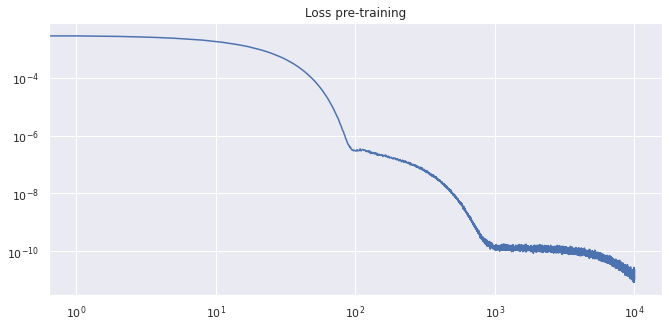

In [14]:
random.seed(seed_number)
nn_AIO.train() #train mode

optimizer = create_optimizer(nn_AIO, params)

# store mean loss by epoch
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
epochs_pre_train = params.nb_epochs
loss_epochs = torch.zeros(epochs_pre_train)
freq_loss = 1000 #frequency with which to display the loss

start_time = time.time()
for i in range(0, epochs_pre_train):
    optimizer.zero_grad() #clear grad
    loss = Ξ_torch_init(nn_AIO, params) #calculate loss
    loss_epochs[[i]] = float(loss.item()) #store value of loss

    # Backpropagation
    loss.backward() #calculate gradient
    optimizer.step() #update neural net's parameter vector

    if i % freq_loss == 0: #Monitor the loss
        loss, current = float(loss.item()), i
        print(f"loss: {loss:>7f}, [{current:>5d}/{epochs_pre_train:>5d}]")
    if (i % params.freq_scheduler == 0) & (i != 0) & (params.use_scheduler == True):
        scheduler.step()
        print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))
    if (i % 1000 == 0) & (params.optimizer == "Adam"):
        effective_lr = calculate_effective_lr(optimizer)
        print(f"effective lr: {effective_lr}")
        print(f"mult factor: {effective_lr/params.lr}")
elasped_time_AIO = time.time() - start_time
print("--- {} seconds ---".format(elasped_time_AIO ))

if params.optimizer == "SWA":
    optimizer.swap_swa_sgd()

# Switch to evaluation mode
nn_AIO.eval()

# Create a copy
nn_AIO_pre_trained = copy.deepcopy(nn_AIO)

plt.plot(np.abs(loss_epochs))
plt.xscale('log')
plt.yscale('log')
plt.title('Loss pre-training')

4.4107437e-06


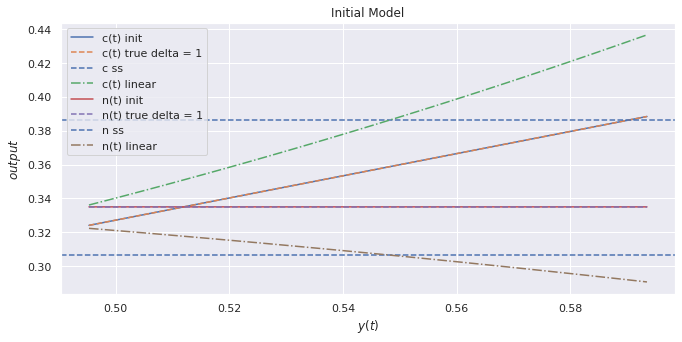

In [15]:
nn_AIO.eval() #Evaluation mode
nb_points = 100 #for plotting

with torch.no_grad():
    # grid for kt-1
    k_min_1 = torch.linspace(params.x_low, params.x_high, nb_points).unsqueeze(1) #add a dimension
    at = torch.ones(len(k_min_1 )).unsqueeze(1) #add a dimension
    # grid for y(t):
    #yt = params.f(at, k_min_1, params.n_cst)
    state_vec = torch.column_stack([k_min_1, at])
    ct_AIO, nt_AIO = model_normalized(state_vec, nn_AIO, params)
    # get the sigmoids from nn:
    # Normalize kt-1 to be between -1 and 1
    k_min_1_normalized = (k_min_1 - params.x_low)/(params.x_high - params.x_low)*2.0 - 1.0
    # Z-score divided by 2. most of the time between -1 and 1
    a_t_normalized = (at - params.mean_a)/(2*params.std_a)
    # 3. recover consumption
    yt = params.f(at, k_min_1, nt_AIO)
    #ct_AIO = phi_c_t*yt
    #V3. Predict the linearized model
    ct_linear = params.c_linear(k_min_1, at)
    nt_linear = params.n_linear(k_min_1, at)

ct_AIO_init = ct_AIO.detach().numpy()
nt_AIO_init = nt_AIO.detach().numpy()
yt = yt.detach().numpy()
# true values (when delta = 1.0)
ct_true = params.c_delta_one(yt)
nt_true = params.n_cst*np.ones(ct_true.shape)

plt.title("ANN BEFORE TRAINING")
#plt.plot(yt, yt, linestyle='--', color='black')
plt.plot(yt, ct_AIO_init, label='c(t) init')
plt.plot(yt, ct_true, label='c(t) true delta = 1', linestyle  ="--")
plt.axhline(y=params.c_ss_tensor.detach().numpy(), label='c ss', linestyle  ="--") 
plt.plot(yt, ct_linear.detach().numpy(), label='c(t) linear', linestyle  ="-.")
plt.plot(yt, nt_AIO_init, label='n(t) init')
plt.plot(yt, nt_true, label='n(t) true delta = 1', linestyle  ="--")
plt.axhline(y=params.n_ss_tensor.detach().numpy(), label='n ss', linestyle  ="--") 
plt.plot(yt, nt_linear.detach().numpy(), label='n(t) linear', linestyle  ="-.")
plt.xlabel("$y(t)$")
plt.ylabel("$output$")
plt.title("Initial Model")
plt.legend()
plt.savefig(output_folder + "Initialization_AIO.png")
print(np.max(np.abs(nt_AIO_init - params.n_cst)))

In [16]:
%%time
with torch.no_grad():
    v = Ξ_torch(nn_AIO, params)
    print(v)
    print(torch.sqrt(v)) #take sqrt because this the square of Euler resid

tensor(0.0001544965)
tensor(0.0124296620)
CPU times: user 16.4 ms, sys: 3.82 ms, total: 20.2 ms
Wall time: 5.94 ms


####  III.A.2. Training loop for NN

Starting form the initialized NN, train the NN on the "real" DSGE model.

In [17]:
random.seed(seed_number)
nn_AIO.train()

optimizer = create_optimizer(nn_AIO, params)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
loss_epochs = torch.zeros(params.nb_epochs)
# Euler equation error
list_Euler_err_AIO = [] #store median euler error on grid
list_Euler_err_AIO_mean = [] #store mean euler error on grid
list_Euler_err_AIO_i = [] #store index i
list_Euler_err_AIO_loss = [] #store loss

freq_loss = 10 #frequency with which to calcualte euler error
freq_display_loss = 100
calculate_euler_error=True #very slow when true

start_time = time.time()
for i in range(0, params.nb_epochs):
    optimizer.zero_grad()
    loss = Ξ_torch(nn_AIO, params)
    loss_epochs[[i]] = float(loss.item())

    # Backpropagation
    loss.backward()
    # Clip gradient to prevent potential explosive patterns
    clip_grad_norm_(nn_AIO.parameters(), max_norm=1.0, error_if_nonfinite=False)
    optimizer.step()

    if i % freq_loss == 0: #Monitor Euler error
        if calculate_euler_error == True:
            # Switch to evaluation mode
            nn_AIO.eval()
            with torch.no_grad():
            # Euler equation error
                ## New draws
                ### Gaussian
                if use_Gaussian_quadrature == True:
                    state_vec = generate_state_vec(params.M_accuracy, params)
                    euler_err = evaluate_accuracy_pytorch_Gaussian(nn_AIO, params, state_vec[:, 0], state_vec[:, 1], torch.tensor([1e-6]), False, False, distance_f)
                ##Monte Carlo
                else:
                    state_vec = generate_state_vec(params.M_accuracy, params)
                    euler_err = evaluate_accuracy_pytorch_MC(nn_AIO, params, state_vec[:, 0], state_vec[:, 1], params.N_accuracy, torch.tensor([1e-6]), False, False, distance_f)
                ## Reuse same draws
                # euler_err = evaluate_accuracy_pytorch_Gaussian_frozen(nn_AIO, params, torch.tensor([1e-6]), False, False, distance_f)
                if use_RMSE == True:
                    list_Euler_err_AIO.append(np.sqrt(np.median(euler_err))) #median value for euler error 
                    list_Euler_err_AIO_mean.append(np.sqrt(np.mean(euler_err)))
                else:
                    list_Euler_err_AIO.append(np.median(euler_err)) #median value for euler error 
                    list_Euler_err_AIO_mean.append(np.mean(euler_err))
                list_Euler_err_AIO_i.append(i)
                list_Euler_err_AIO_loss.append(loss.item())
            # Switch back to training mode
            nn_AIO.train() 

    if i % freq_display_loss == 0: #Monitor the loss
        loss, current = float(loss.item()), i
        print(f"loss: {loss:>7f}, [{current:>5d}/{params.nb_epochs:>5d}]")
    if (i % params.freq_scheduler == 0) & (i != 0) & (params.use_scheduler == True):
        scheduler.step()
        print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))
    if (i % 1000 == 0) & (params.optimizer == "Adam"):
        effective_lr = calculate_effective_lr(optimizer)
        print(f"mult factor: {effective_lr/params.lr}")
        print(f"effective lr: {effective_lr}")
elasped_time_AIO = time.time() - start_time
print("--- {} seconds ---".format(elasped_time_AIO ))

if params.optimizer == "SWA":
    optimizer.swap_swa_sgd()

# Switch to evaluation mode
nn_AIO.eval()

loss: 0.000157, [    0/10000]
mult factor: 1584.4323158264158
effective lr: 1.5844323158264157
loss: 0.000040, [  100/10000]
loss: 0.000036, [  200/10000]
loss: 0.000028, [  300/10000]
loss: 0.000014, [  400/10000]
loss: 0.000005, [  500/10000]
loss: 0.000002, [  600/10000]
loss: -0.000002, [  700/10000]
loss: -0.000000, [  800/10000]
loss: -0.000000, [  900/10000]
loss: 0.000001, [ 1000/10000]
mult factor: 2115.349388122558
effective lr: 2.1153493881225582
loss: 0.000000, [ 1100/10000]
loss: 0.000001, [ 1200/10000]
loss: 0.000001, [ 1300/10000]
loss: 0.000001, [ 1400/10000]
loss: 0.000001, [ 1500/10000]
loss: 0.000002, [ 1600/10000]
loss: -0.000001, [ 1700/10000]
loss: 0.000001, [ 1800/10000]
loss: -0.000001, [ 1900/10000]
loss: 0.000001, [ 2000/10000]
mult factor: 3614.761734008788
effective lr: 3.614761734008788
loss: 0.000002, [ 2100/10000]
loss: 0.000001, [ 2200/10000]
loss: 0.000000, [ 2300/10000]
loss: 0.000002, [ 2400/10000]
loss: 0.000002, [ 2500/10000]
loss: 0.000002, [ 2600/

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): Sigmoid()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): Dropout(p=0.0, inplace=False)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

Last value MA series sqrt abs loss: 0.0008901690809580032


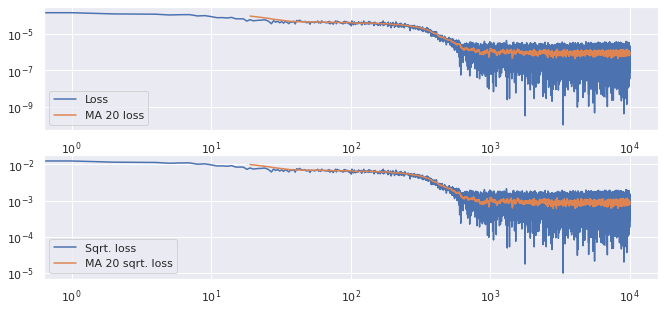

In [18]:
rate = 20

fig, axs = plt.subplots(2)
axs[0].plot(np.abs(loss_epochs), label="Loss")
axs[0].plot(pd.Series(np.abs(loss_epochs)).rolling(rate).mean(), label= f'MA {rate} loss') 
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

axs[1].plot(torch.sqrt(np.abs(loss_epochs)), label="Sqrt. loss") #expectation over state of the euler error squared. Take sqrt
MA_series = pd.Series(torch.sqrt(np.abs(loss_epochs))).rolling(rate).mean()
axs[1].plot(MA_series, label= f'MA {rate} sqrt. loss') #expectation over state of the euler error squared. Take sqrt
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()
figname = output_folder + 'Loss_NN.png'
plt.savefig(figname)
print(f"Last value MA series sqrt abs loss: {MA_series[len(MA_series)-1]}")

In [19]:
tol = torch.tensor([1e-6])
debug = False #evalute euler error use formula for delta=1.0

print('AFTER training')
for use_linear in [True, False]:
    euler_err = evaluate_accuracy_pytorch_MC_frozen(nn_AIO, params, tol, use_linear, debug, distance_f)
    print(f"MC. Linearized model : {use_linear}")
    print(f"Median dist. error: {np.median(euler_err)}")
    print(f"Mean dist. error: {np.mean(euler_err)}")
    print(f"Minimum dist. error: {np.min(euler_err)}")
    print(f"Maximum dist. error: {np.max(euler_err)}")
    print(f"Stdev dist. error: {np.std(euler_err)}")
    print(f"------------------------------------")
    euler_err = evaluate_accuracy_pytorch_Gaussian_frozen(nn_AIO, params, tol, use_linear, debug, distance_f)
    print(f"gaussian quadrature. Linearized model : {use_linear}")
    print(f"Median dist. error: {np.median(euler_err)}")
    print(f"Mean dist. error: {np.mean(euler_err)}")
    print(f"Minimum dist. error: {np.min(euler_err)}")
    print(f"Maximum dist. error: {np.max(euler_err)}")
    print(f"Stdev dist. error: {np.std(euler_err)}")
    print(f"------------------------------------")

with torch.no_grad():
    v = Ξ_torch(nn_AIO, params)
    print(v)
    print(torch.sqrt(torch.abs(v)))

AFTER training
MC. Linearized model : True
Median dist. error: 0.00046628713607788086
Mean dist. error: 0.00057834608014673
Minimum dist. error: 8.344650268554688e-07
Maximum dist. error: 0.003407418727874756
Stdev dist. error: 0.0004671138012781739
------------------------------------
gaussian quadrature. Linearized model : True
Median dist. error: 0.00012540817260742188
Mean dist. error: 0.00028014995041303337
Minimum dist. error: 1.1920928955078125e-07
Maximum dist. error: 0.003004908561706543
Stdev dist. error: 0.0003898623399436474
------------------------------------
MC. Linearized model : False
Median dist. error: 0.0004239380359649658
Mean dist. error: 0.0005145050818100572
Minimum dist. error: 5.960464477539062e-07
Maximum dist. error: 0.0031348466873168945
Stdev dist. error: 0.00042345092515461147
------------------------------------
gaussian quadrature. Linearized model : False
Median dist. error: 0.00017836689949035645
Mean dist. error: 0.00020140832930337638
Minimum dist. 

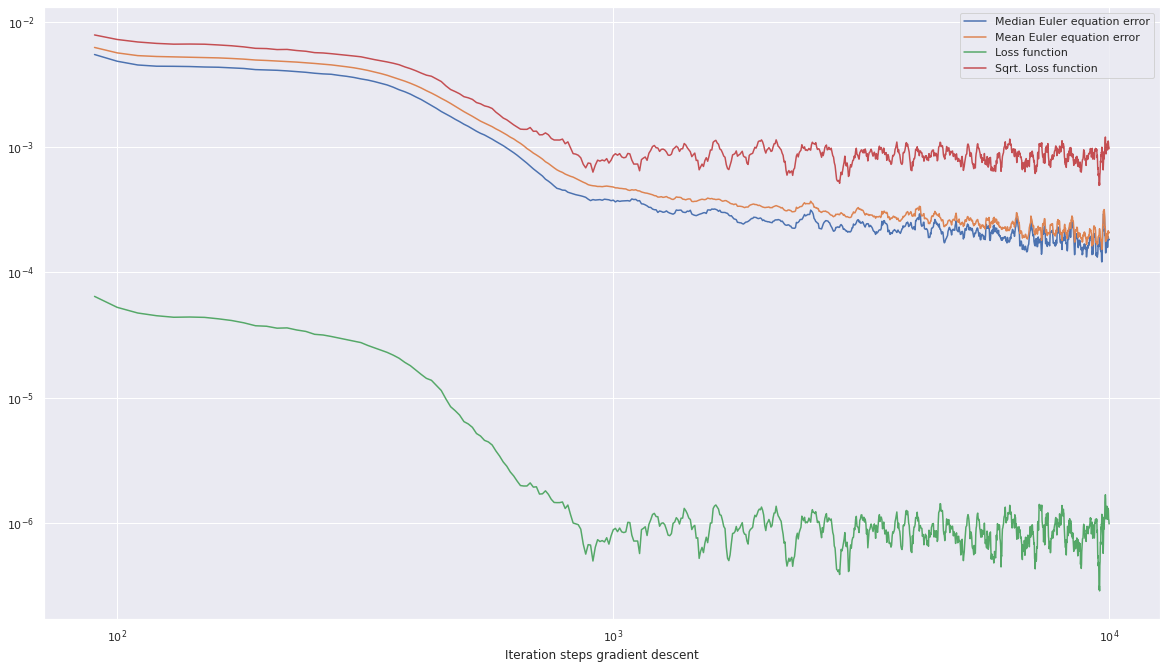

In [20]:
plot_scale = 1.25
rate=10
plt.rcParams["figure.figsize"] = (plot_scale*16, plot_scale*9)

plt.plot(list_Euler_err_AIO_i, pd.Series(list_Euler_err_AIO).rolling(rate).mean(), label="Median Euler equation error")
plt.plot(list_Euler_err_AIO_i, pd.Series(list_Euler_err_AIO_mean).rolling(rate).mean(), label="Mean Euler equation error")
plt.plot(list_Euler_err_AIO_i, pd.Series(np.abs(list_Euler_err_AIO_loss)).rolling(rate).mean(), label="Loss function")
plt.plot(list_Euler_err_AIO_i, pd.Series(np.sqrt(np.abs(list_Euler_err_AIO_loss))).rolling(rate).mean(), label="Sqrt. Loss function")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration steps gradient descent')
#plt.ylabel('Median Euler equation error')
plt.legend()
figname = output_folder + 'loss-and-errors.png'
plt.savefig(figname)

In [21]:
print("Correlation between loss function and median euler error.")
np.corrcoef(list_Euler_err_AIO_loss, list_Euler_err_AIO)

Correlation between loss function and median euler error.


array([[1.        , 0.95301654],
       [0.95301654, 1.        ]])

In [22]:
print("Correlation between loss function and mean euler error.")
np.corrcoef(list_Euler_err_AIO_loss, list_Euler_err_AIO_mean)

Correlation between loss function and mean euler error.


array([[1.        , 0.93751784],
       [0.93751784, 1.        ]])

###  IV. Deep Learning vs 1st order linearization

Compare the DL solution to the 1st order linearization solution.

#### IV.A Plot policy functions

Let's plot policy functions obtained using the two methodologies.

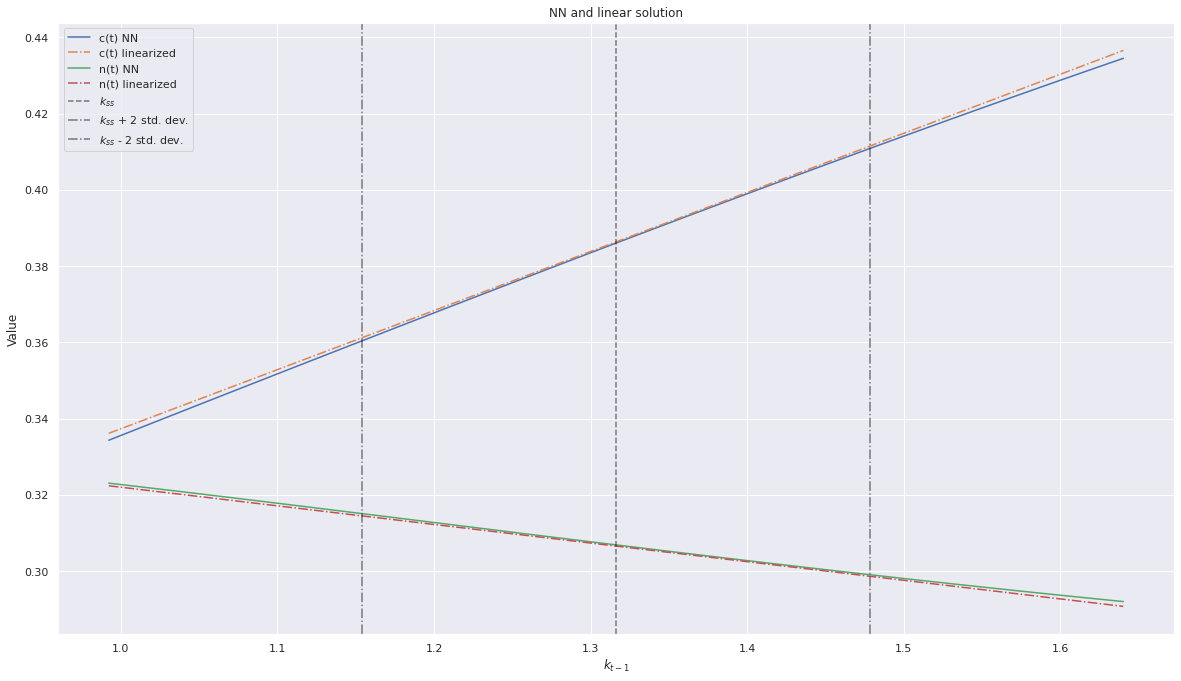

In [23]:
nn_AIO.eval() #Evaluation mode
nb_points = 100 #for plotting

with torch.no_grad():
    # grid for kt-1
    #k_min_1 = torch.linspace(0.05, 0.5, nb_points).unsqueeze(1) #add a dimension
    k_min_1 = torch.linspace(params.x_low, params.x_high, nb_points).unsqueeze(1) #add a dimension
    at = torch.ones(len(k_min_1 )).unsqueeze(1) #add a dimension
    state_vec = torch.column_stack([k_min_1, at])
    ct_AIO, nt_AIO = model_normalized(state_vec, nn_AIO, params)
    k_min_1 = k_min_1.detach().numpy()
    at = at.detach().numpy()
    ct_linear = params.c_linear(k_min_1, at)
    nt_linear = params.n_linear(k_min_1, at)

ct_AIO = ct_AIO.detach().numpy()
nt_AIO = nt_AIO.detach().numpy()

# true values (when delta = 1.0)
ct_true = params.c_delta_one(yt)
nt_true = params.n_cst*np.ones(ct_true.shape)

plt.title("ANN AFTER TRAINING")
plt.plot(k_min_1, ct_AIO, label='c(t) NN')
plt.plot(k_min_1, ct_linear, label='c(t) linearized', linestyle  ="-.")

plt.plot(k_min_1, nt_AIO, label='n(t) NN')
plt.plot(k_min_1, nt_linear, label='n(t) linearized', linestyle  ="-.")

plt.axvline(x = X_SS[params.names.index("K")], linestyle  ="--", label="$k_{ss}$", color="black", alpha=0.5)
plt.axvline(x = X_SS[params.names.index("K")] + 2*params.stdev_K_linear, linestyle  ="-.", label="$k_{ss}$ + 2 std. dev.", color="black", alpha=0.5)
plt.axvline(x = X_SS[params.names.index("K")] - 2*params.stdev_K_linear, linestyle  ="-.", label="$k_{ss}$ - 2 std. dev.", color="black", alpha=0.5)
plt.xlabel("$k_{t-1}$")
plt.ylabel("Value")
plt.title("NN and linear solution")
plt.legend()
plt.savefig(output_folder + "Trained_AIO_and_linearized.png", dpi=600)
plt.savefig(output_folder + "Trained_AIO_and_linearized.pdf", dpi=600)


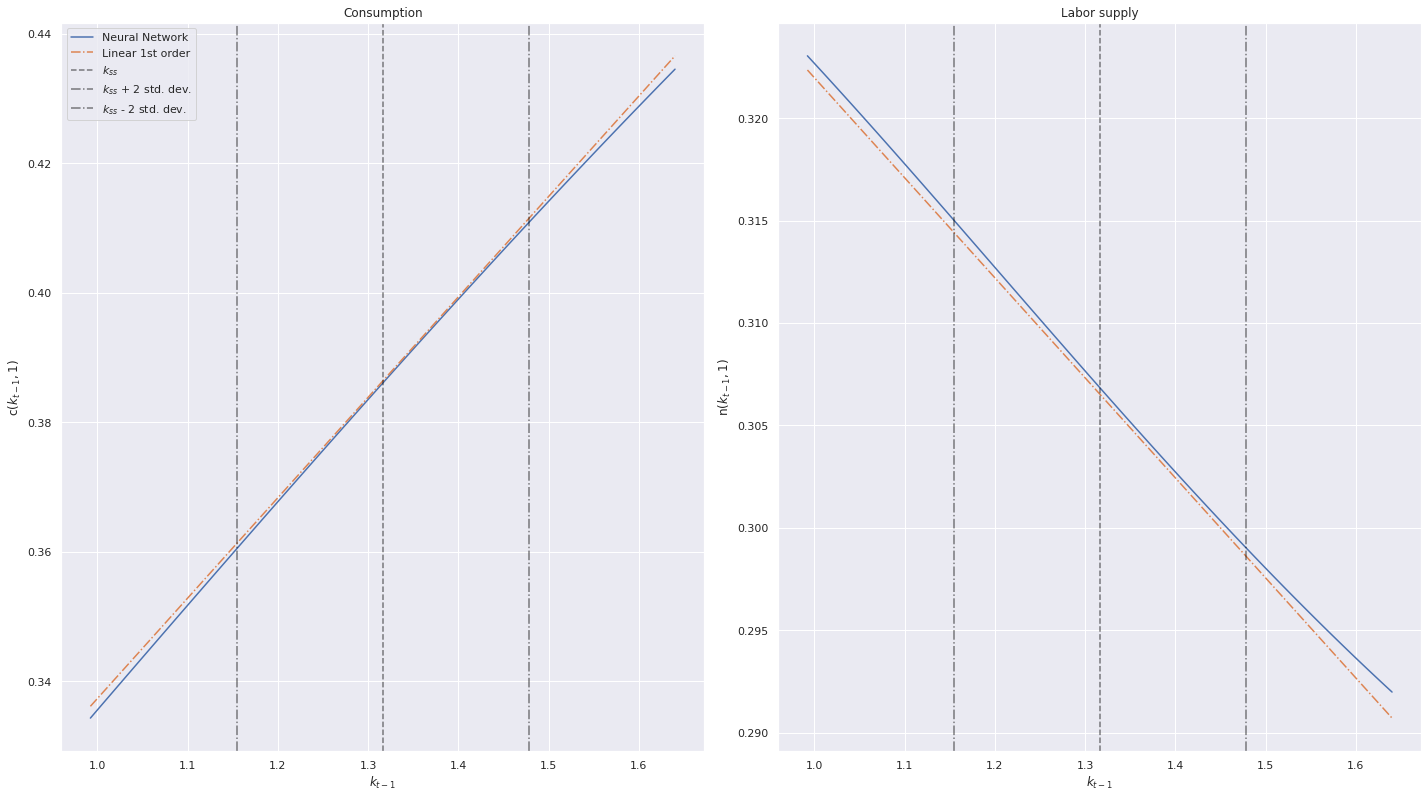

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(k_min_1, ct_AIO, label='Neural Network')
ax1.plot(k_min_1, ct_linear, label='Linear 1st order', linestyle  ="-.")

ax2.plot(k_min_1, nt_AIO, label='Neural Network')
ax2.plot(k_min_1, nt_linear, label='Linear 1st order', linestyle  ="-.")

ax1.axvline(x = X_SS[params.names.index("K")], linestyle  ="--", label="$k_{ss}$", color="black", alpha=0.5)
ax1.axvline(x = X_SS[params.names.index("K")] + 2*params.stdev_K_linear, linestyle  ="-.", label="$k_{ss}$ + 2 std. dev.", color="black", alpha=0.5)
ax1.axvline(x = X_SS[params.names.index("K")] - 2*params.stdev_K_linear, linestyle  ="-.", label="$k_{ss}$ - 2 std. dev.", color="black", alpha=0.5)
ax2.axvline(x = X_SS[params.names.index("K")], linestyle  ="--", label="$k_{ss}$", color="black", alpha=0.5)
ax2.axvline(x = X_SS[params.names.index("K")] + 2*params.stdev_K_linear, linestyle  ="-.", label="$k_{ss}$ + 2 std. dev.", color="black", alpha=0.5)
ax2.axvline(x = X_SS[params.names.index("K")] - 2*params.stdev_K_linear, linestyle  ="-.", label="$k_{ss}$ - 2 std. dev.", color="black", alpha=0.5)

ax1.set_xlabel("$k_{t-1}$")
ax2.set_xlabel("$k_{t-1}$")
ax1.set_ylabel("c($k_{t-1}, 1)$")
ax2.set_ylabel("n$(k_{t-1}, 1)$")
ax1.set_title("Consumption")
ax2.set_title("Labor supply")
ax1.legend()
fig.tight_layout()
    
plt.savefig(output_folder + "Trained_AIO_and_linearized.png", dpi=600)
plt.savefig(output_folder + "Trained_AIO_and_linearized.pdf", dpi=600)

In [25]:
# save to disk
k_ss = X_SS[params.names.index("K")]
k_ss_low_ci = X_SS[params.names.index("K")] - 2*params.stdev_K_linear
k_ss_high_ci = X_SS[params.names.index("K")] + 2*params.stdev_K_linear

df_policy = pd.DataFrame({'k': k_min_1.squeeze(), 'ct_AIO': ct_AIO.squeeze(), 'ct_linear': ct_linear.squeeze(),
                         'nt_AIO': nt_AIO.squeeze(), 'nt_linear': nt_linear.squeeze(),
                         'k_ss': k_ss, 'k_ss_low_ci': k_ss_low_ci, 'k_ss_high_ci': k_ss_high_ci})
print(df_policy.head())
print(output_folder)
df_policy.to_csv(output_folder + 'df_policy.csv', index=False)

          k    ct_AIO  ct_linear    nt_AIO  nt_linear      k_ss  k_ss_low_ci  \
0  0.992366  0.334305   0.336127  0.323044   0.322351  1.316253     1.154309   
1  0.998909  0.335369   0.337142  0.322731   0.322032  1.316253     1.154309   
2  1.005452  0.336431   0.338156  0.322418   0.321712  1.316253     1.154309   
3  1.011995  0.337493   0.339171  0.322103   0.321392  1.316253     1.154309   
4  1.018538  0.338554   0.340185  0.321787   0.321073  1.316253     1.154309   

   k_ss_high_ci  
0      1.478197  
1      1.478197  
2      1.478197  
3      1.478197  
4      1.478197  
/home/julien/Documents/REPOSITORIES/Deep_Learning_DSGE/output/


#### III.B Ergodic simulations

Run stochastic simulations and compare histograms and density plots.

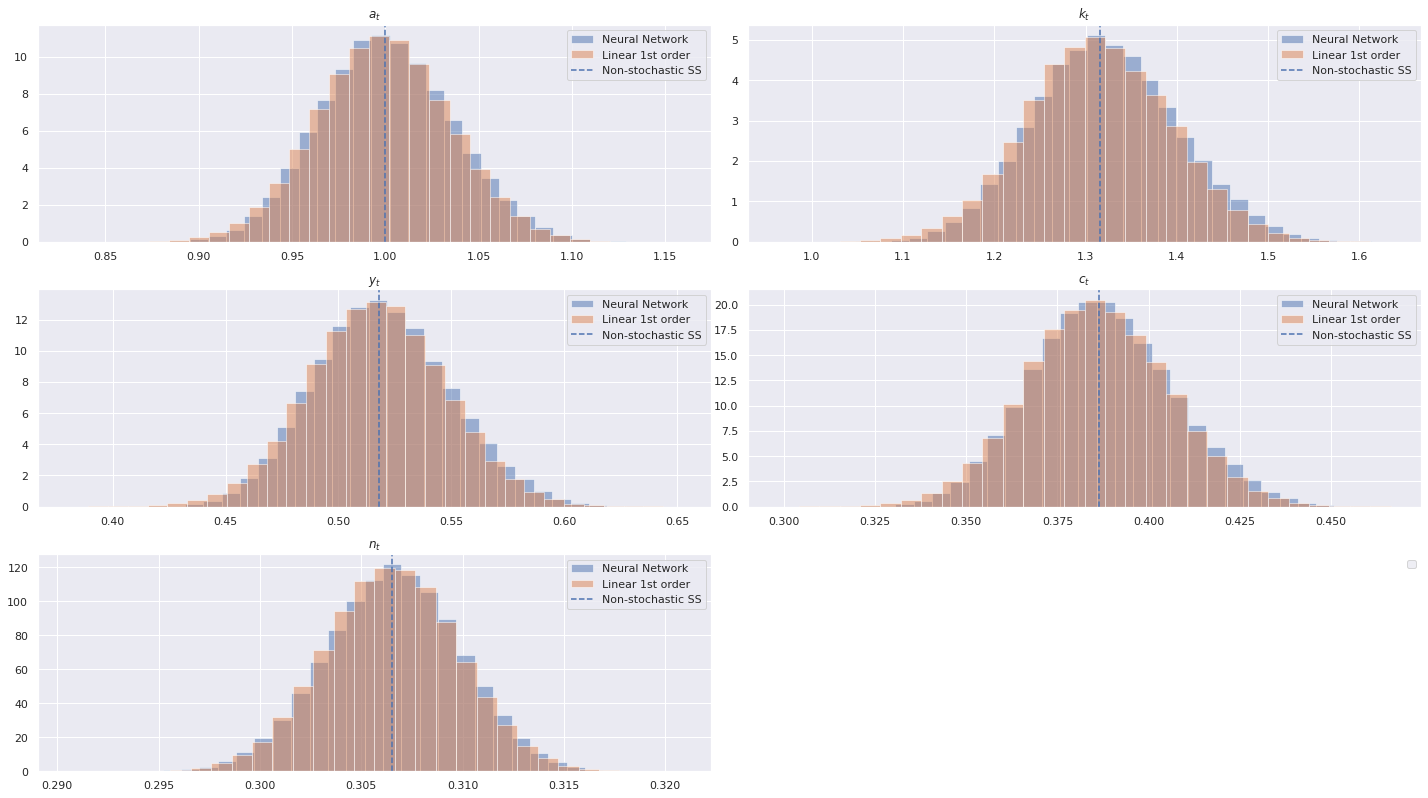

In [26]:
#NN
len_simul = 100000
series, names = simul_model(nn_AIO, params, len_simul)
# Linear
X_SS, X_t, c_linear, n_linear, k_linear = solve_simulate_linearized(rbc, len_simul)

# Plot histogram
plot_series = False
if plot_series == True:
    fig, axs =  plt.subplots(3, 2)
    # IRF: deviation from SS
    for (i, (n, ax)) in enumerate(zip(names, axs.flat) ):
        ax.plot(series[:, i].detach().numpy(), label="nn")
        ax.set_title(n)
    plt.legend()
    fig.tight_layout()

fig, axs =  plt.subplots(3, 2)
bins_size = 30
names_long = ['$a_t$', '$k_t$', '$y_t$', '$c_t$', '$n_t$']
# IRF: deviation from SS
for (i, (n, n_long, ax)) in enumerate(zip(names, names_long, axs.flat) ):
    ax.hist(series[:, i].detach().numpy(), label="Neural Network", alpha=0.5, bins=bins_size, density=True)
    ax.hist(X_t[i, :], label="Linear 1st order", alpha=0.5, bins=bins_size, density=True)
    ax.axvline(x = X_SS[params.names.index(n)], linestyle  ="--", label="Non-stochastic SS")        
    ax.set_title(n_long)
    ax.legend()

axs[-1, -1].axis('off')
plt.legend()
fig.tight_layout()

plt.savefig(output_folder + "Trained_AIO_and_linearized_simul.png", dpi=600)
plt.savefig(output_folder + "Trained_AIO_and_linearized_simul.pdf", dpi=600)

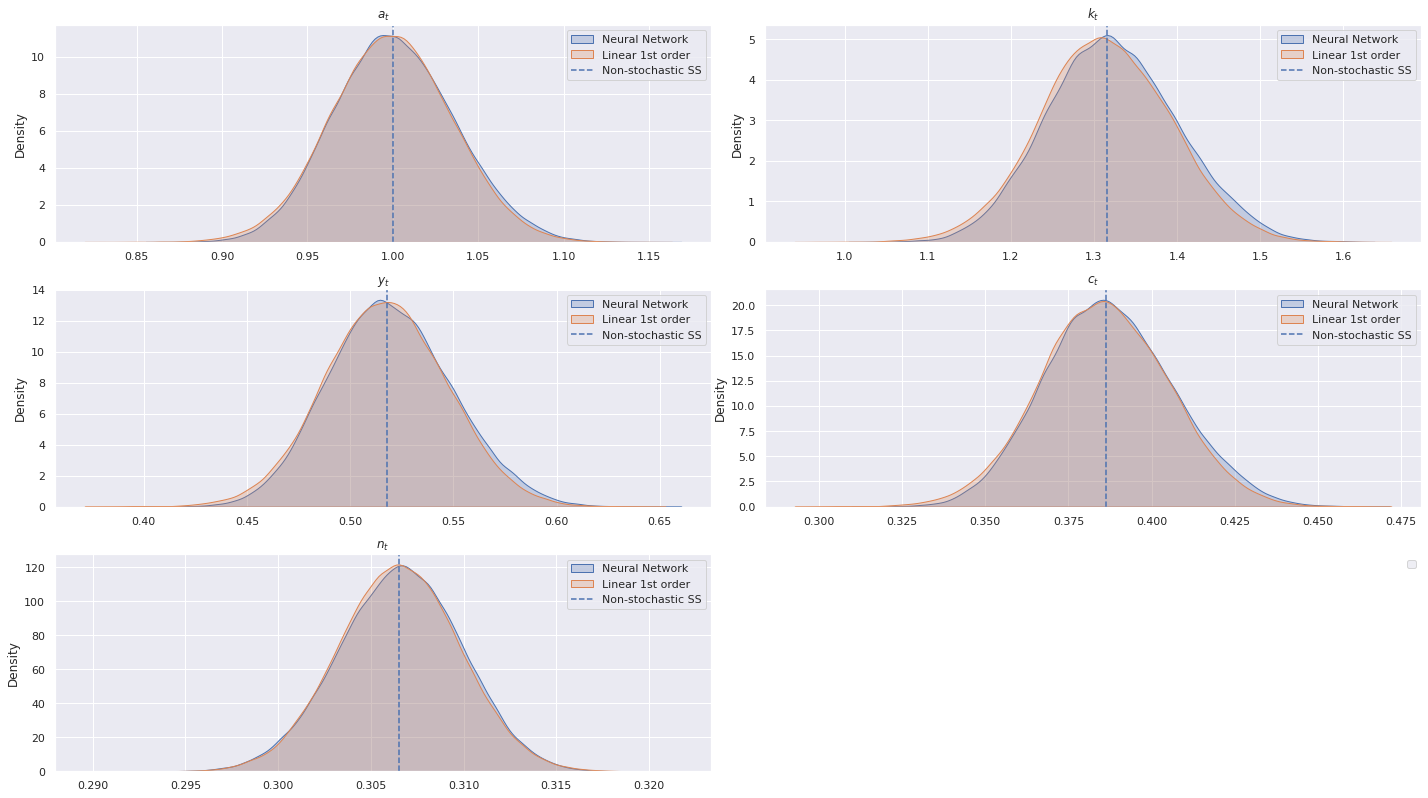

In [27]:
# Plot density
plot_series = False
if plot_series == True:
    fig, axs =  plt.subplots(3, 2)
    # IRF: deviation from SS
    for (i, (n, ax)) in enumerate(zip(names, axs.flat) ):
        ax.plot(series[:, i].detach().numpy(), label="nn")
        ax.set_title(n)
    plt.legend()
    fig.tight_layout()

fig, axs =  plt.subplots(3, 2)
bins_size = 30
names_long = ['$a_t$', '$k_t$', '$y_t$', '$c_t$', '$n_t$']
# IRF: deviation from SS
for (i, (n, n_long, ax)) in enumerate(zip(names, names_long, axs.flat) ):
    sns.kdeplot(series[:, i].detach().numpy(), ax=ax, label="Neural Network", fill=True, alpha=0.25)
    sns.kdeplot(X_t[i, :], ax=ax, label="Linear 1st order", fill=True, alpha=0.25)
    ax.axvline(x = X_SS[params.names.index(n)], linestyle  ="--", label="Non-stochastic SS")        
    ax.set_title(n_long)
    ax.legend()
    
axs[-1, -1].axis('off')
plt.legend()
fig.tight_layout()

plt.savefig(output_folder + "Trained_AIO_and_linearized_simul_kde.png", dpi=600)
plt.savefig(output_folder + "Trained_AIO_and_linearized_simul_kde.pdf", dpi=600)

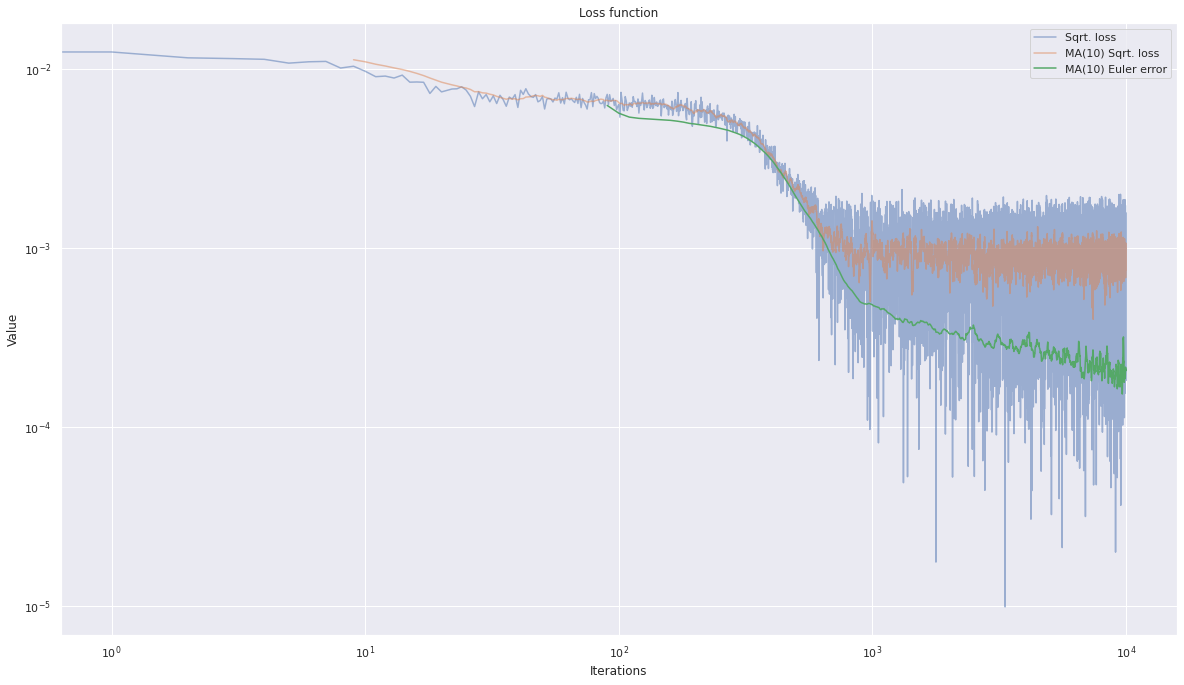

In [28]:
plot_scale = 1.25
rate=1
last_N_values = 2
plt.rcParams["figure.figsize"] = (plot_scale*16, plot_scale*9)
fig, (ax1) = plt.subplots(1, 1)

rate = 10
#fig.suptitle('Horizontally stacked subplots')
ax1.plot(pd.Series(np.sqrt( np.abs(loss_epochs))).rolling(1).mean(), label="Sqrt. loss", alpha=0.5)
ax1.plot(pd.Series(np.sqrt( np.abs(loss_epochs))).rolling(rate).mean(), label=f"MA({rate}) Sqrt. loss", alpha=0.5)
ax1.plot(list_Euler_err_AIO_i, pd.Series(list_Euler_err_AIO_mean).rolling(rate).mean(), label=f"MA({rate}) Euler error")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Value')
ax1.set_xlabel('Iterations')
ax1.set_title('Loss function')
ax1.legend()


#plt.suptitle("Loss function and absol".format(params.σ_e), fontsize=14)
figname = output_folder + 'summmary_MC_bc.png'
plt.savefig(figname, dpi=600)

figname = output_folder + 'summmary_MC_bc.pdf'
plt.savefig(figname, dpi=600)

plt.show()

#### IV.C Accuracy of solutions

Compare accuracy using the unit-less Euler equation error (EEE):

$$ EEE(k_t, a_t) = 1 - \Big(\beta E \Big[ \frac{c_t}{c_{t+1}}\big(\alpha \frac{y_{t+1}}{k_t} + 1 -\delta \big) \Big] \Big) ^{-1} $$

**Interpretation:**
* if on average $EEE = 0.01$, agents make a 1 USD mistake for every 100 USD they invest
* if on average $EEE = 0.001$, agents make a 1 USD mistake for every 1000 USD the invest. Etc.

In [29]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False  # not really needed

SMALL_SIZE = 16
MEDIUM_SIZE = SMALL_SIZE+2
BIGGER_SIZE = MEDIUM_SIZE+2

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

nn_AIO.eval() #Evaluation mode
nb_points = 300 #for plotting

with torch.no_grad():
    # grid for kt-1
    k_min_1 = torch.linspace(params.x_low, params.x_high, nb_points) #add a dimension
    at = torch.ones(len(k_min_1 )) #add a dimension
    # Evaluate accuracy
    ## NN
    euler_AIO = evaluate_accuracy_pytorch_Gaussian(nn_AIO, params, k_min_1, at, tol=torch.tensor([1e-6]), use_linear = False, debug = False)
    ## Linear
    euler_linear = evaluate_accuracy_pytorch_Gaussian(nn_AIO, params, k_min_1, at, tol=torch.tensor([1e-6]), use_linear = True, debug = False)


In [30]:
# Export to .csv results
df_log10 = pd.DataFrame({'k_min_1': k_min_1, "a_t": at, "euler_AIO": euler_AIO, "euler_linear": euler_linear})
if save_to_csv == True:
    # Save to csv.
    df_log10.to_csv(output_folder + 'df_log10.csv', index=False)
df_log10.head()

,k_min_1,a_t,euler_AIO,euler_linear
0,0.992366,1.0,0.001978,0.004369
1,0.994532,1.0,0.001933,0.004301
2,0.996698,1.0,0.001888,0.004234
3,0.998865,1.0,0.001844,0.004168
4,1.001031,1.0,0.001800,0.004102


#### IV.C.1 Plot for a single trained NN

Plot $EEE(k_t, 1.0)$, for several values of $k_t$, using Gaussian quadrature for the expectation operator.

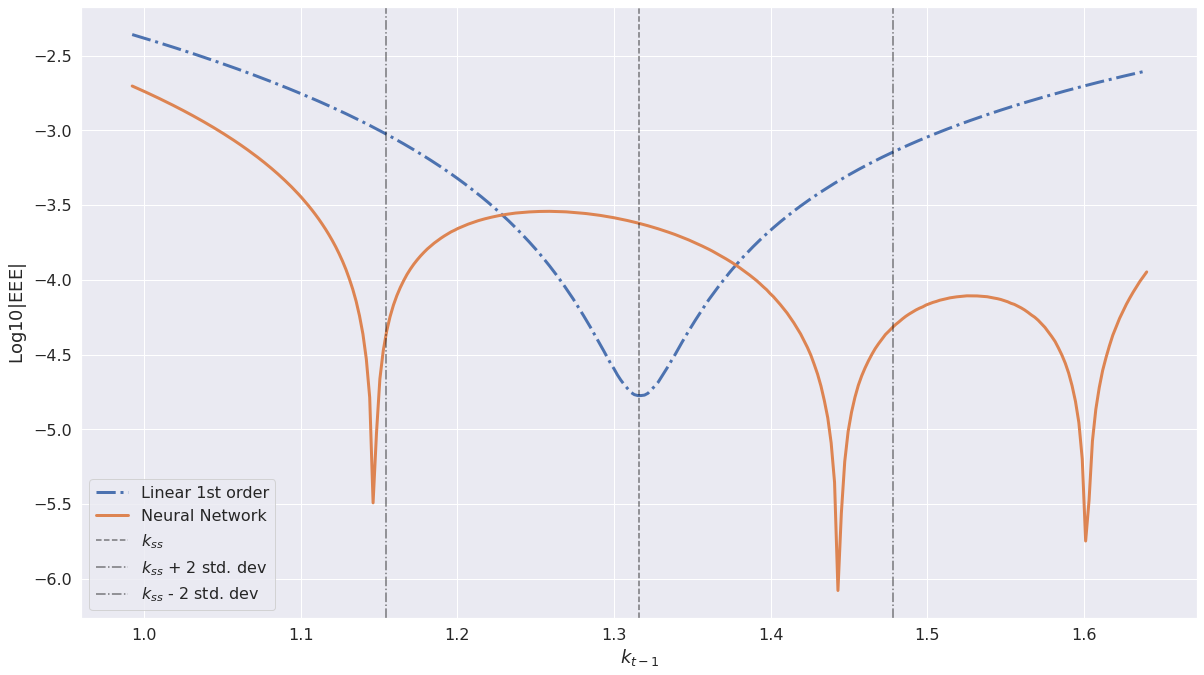

In [31]:
#plt.title("Euler error")
plt.plot(df_log10["k_min_1"], np.log10(df_log10["euler_linear"]), label='Linear 1st order', linestyle  ="-.", linewidth=3)
plt.plot(df_log10["k_min_1"], np.log10(df_log10["euler_AIO"]), label='Neural Network', linewidth=3)
plt.axvline(x = X_SS[params.names.index("K")], linestyle  ="--", label="$k_{ss}$", color="black", alpha=0.5)
plt.axvline(x = X_SS[params.names.index("K")] + 2*params.stdev_K_linear, linestyle  ="-.", label="$k_{ss}$ + 2 std. dev", color="black", alpha=0.5)
plt.axvline(x = X_SS[params.names.index("K")] - 2*params.stdev_K_linear, linestyle  ="-.", label="$k_{ss}$ - 2 std. dev", color="black", alpha=0.5)
plt.xlabel("$k_{t-1}$")
plt.ylabel("$\mathrm{Log10}|\mathrm{EEE}|$")
plt.legend()

figname = output_folder + 'log10_euler.pdf'
plt.savefig(figname, dpi = 600)

#### IV.C.2. Plot for several trained NNs

Because we use Monte Carlo integration to approximate the expectation appearing in the loss function, the loss function is stochatic. With similar starting points, the final parameter vector for the NN will differ between two runs. 

That is why we train 10 NNs and plot the distribution of $EEE(k_t, 1.0)$, for several values of $k_t$.

We do not need to that for the 1st order lineazation solution, because the method is entirely deterministic.

Euler error AIO vs Linear


  0%|                                                    | 0/10 [00:00<?, ?it/s]

loss: 0.000168, [    0/10000]
loss: 0.000001, [ 1000/10000]
loss: 0.000001, [ 2000/10000]
loss: -0.000000, [ 3000/10000]
loss: -0.000000, [ 4000/10000]
loss: 0.000001, [ 5000/10000]
loss: 0.000000, [ 6000/10000]
loss: 0.000001, [ 7000/10000]
loss: 0.000001, [ 8000/10000]
loss: 0.000000, [ 9000/10000]
--- 54.00153136253357 seconds ---


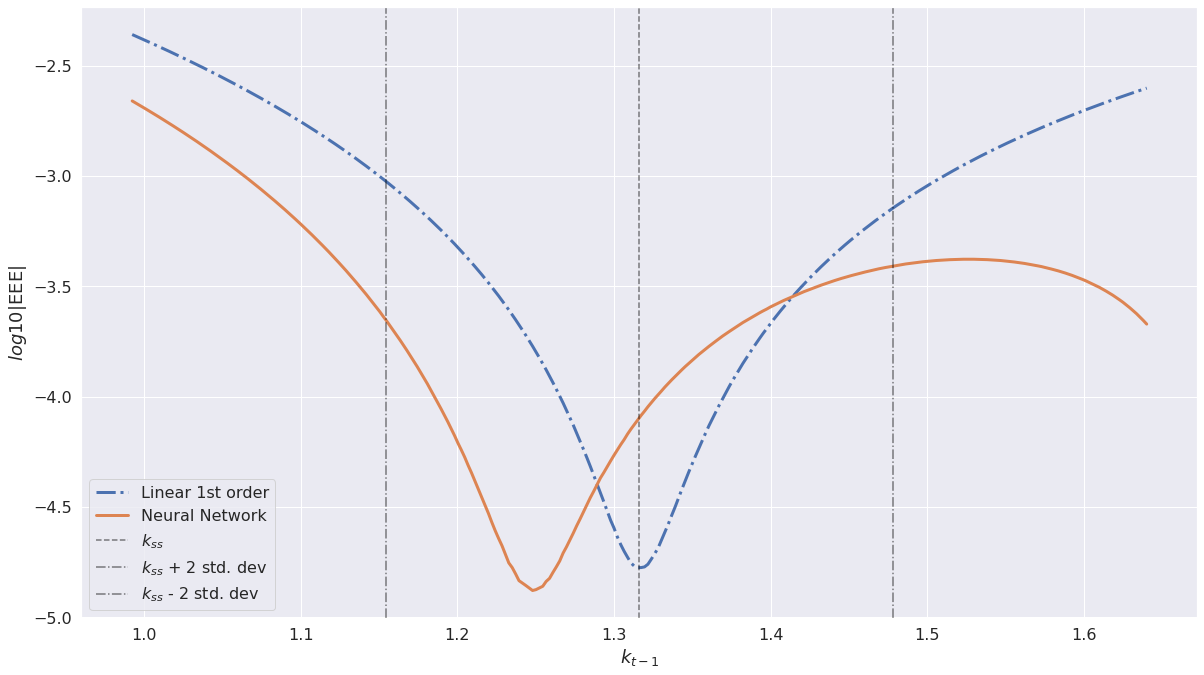

 10%|████▍                                       | 1/10 [00:54<08:08, 54.28s/it]

loss: 0.000170, [    0/10000]
loss: -0.000000, [ 1000/10000]
loss: -0.000002, [ 2000/10000]
loss: -0.000001, [ 3000/10000]
loss: -0.000000, [ 4000/10000]
loss: 0.000001, [ 5000/10000]
loss: -0.000000, [ 6000/10000]
loss: -0.000001, [ 7000/10000]
loss: -0.000000, [ 8000/10000]
loss: 0.000000, [ 9000/10000]
--- 53.97809863090515 seconds ---


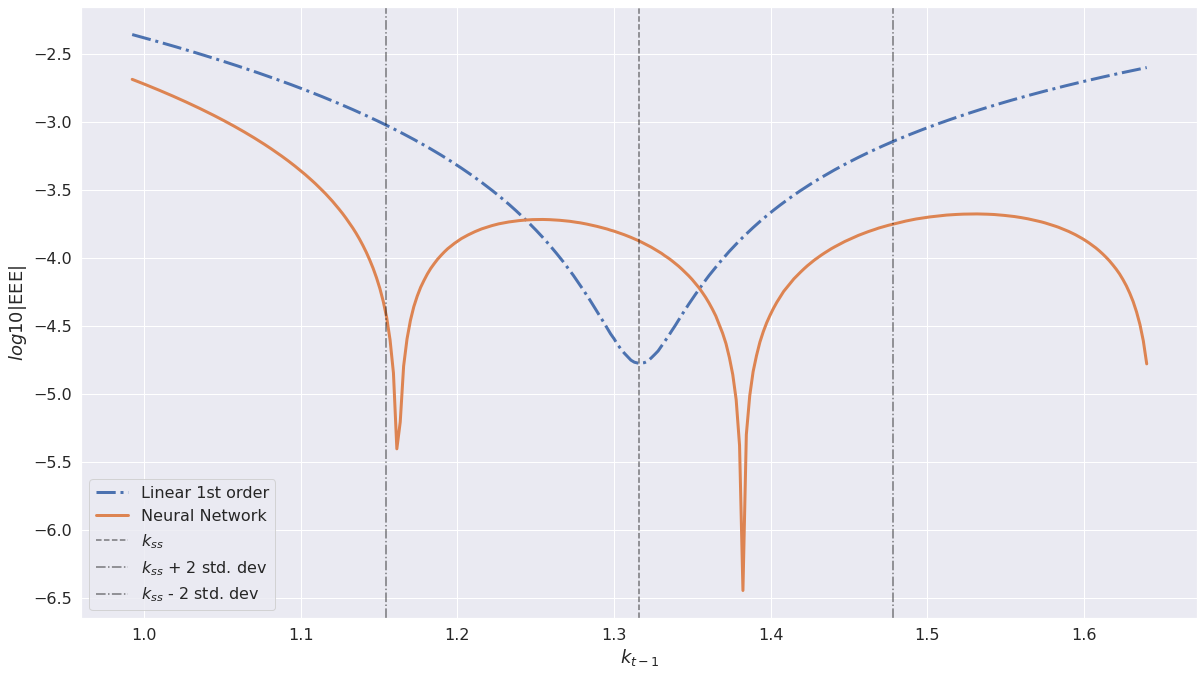

 20%|████████▊                                   | 2/10 [01:48<07:14, 54.30s/it]

loss: 0.000158, [    0/10000]
loss: 0.000000, [ 1000/10000]
loss: -0.000000, [ 2000/10000]
loss: 0.000002, [ 3000/10000]
loss: -0.000000, [ 4000/10000]
loss: 0.000000, [ 5000/10000]
loss: -0.000002, [ 6000/10000]
loss: 0.000000, [ 7000/10000]
loss: -0.000000, [ 8000/10000]
loss: 0.000000, [ 9000/10000]
--- 56.19077944755554 seconds ---


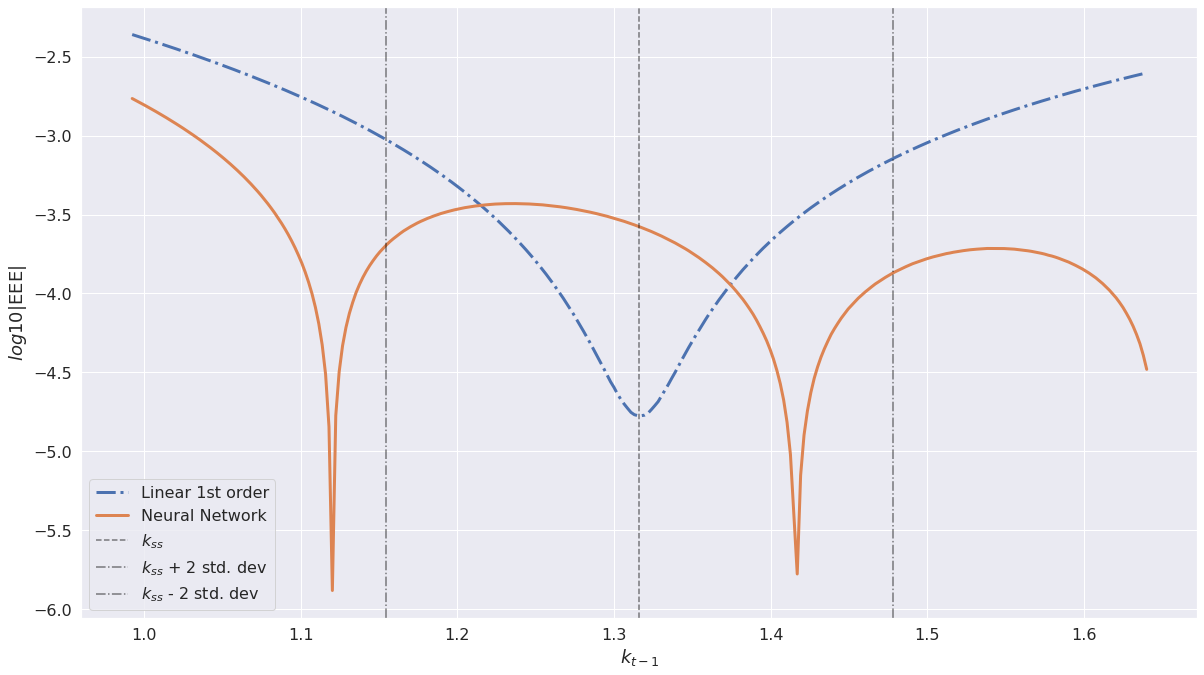

 30%|█████████████▏                              | 3/10 [02:45<06:27, 55.30s/it]

loss: 0.000174, [    0/10000]
loss: 0.000001, [ 1000/10000]
loss: 0.000002, [ 2000/10000]
loss: 0.000001, [ 3000/10000]
loss: -0.000001, [ 4000/10000]
loss: 0.000001, [ 5000/10000]
loss: 0.000001, [ 6000/10000]
loss: -0.000002, [ 7000/10000]
loss: -0.000001, [ 8000/10000]
loss: -0.000002, [ 9000/10000]
--- 52.93461799621582 seconds ---


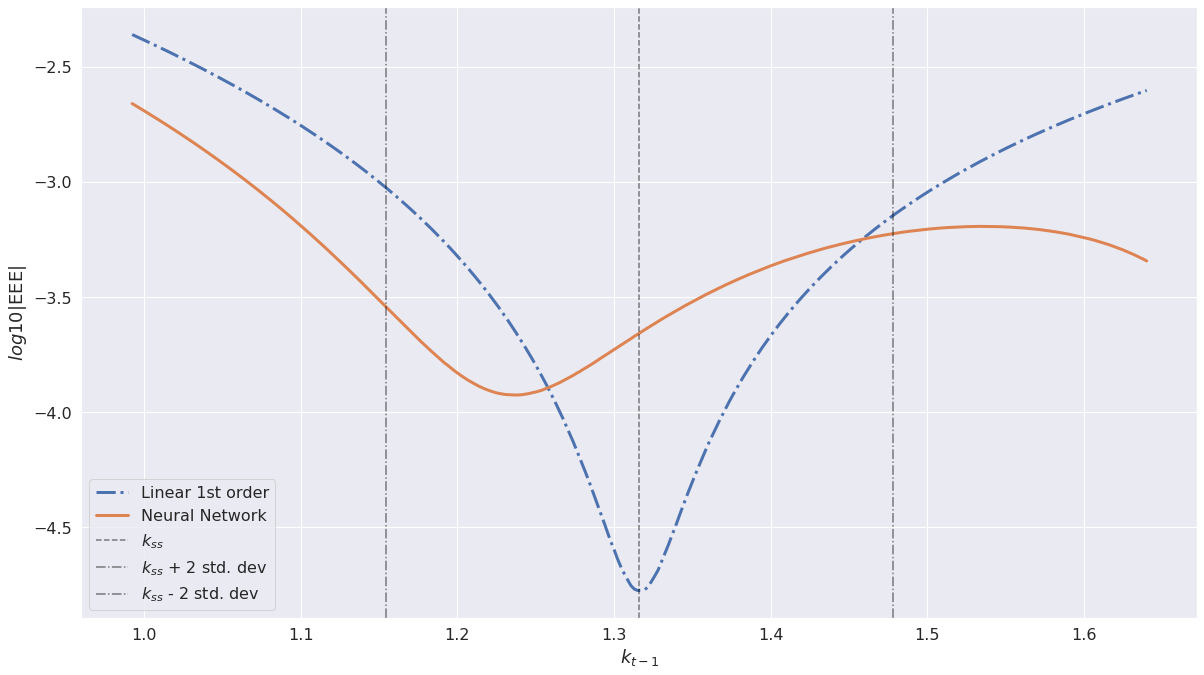

 40%|█████████████████▌                          | 4/10 [03:38<05:26, 54.48s/it]

loss: 0.000147, [    0/10000]
loss: 0.000000, [ 1000/10000]
loss: 0.000000, [ 2000/10000]
loss: -0.000000, [ 3000/10000]
loss: -0.000001, [ 4000/10000]
loss: 0.000000, [ 5000/10000]
loss: -0.000001, [ 6000/10000]
loss: -0.000001, [ 7000/10000]
loss: 0.000000, [ 8000/10000]
loss: 0.000001, [ 9000/10000]
--- 60.60460948944092 seconds ---


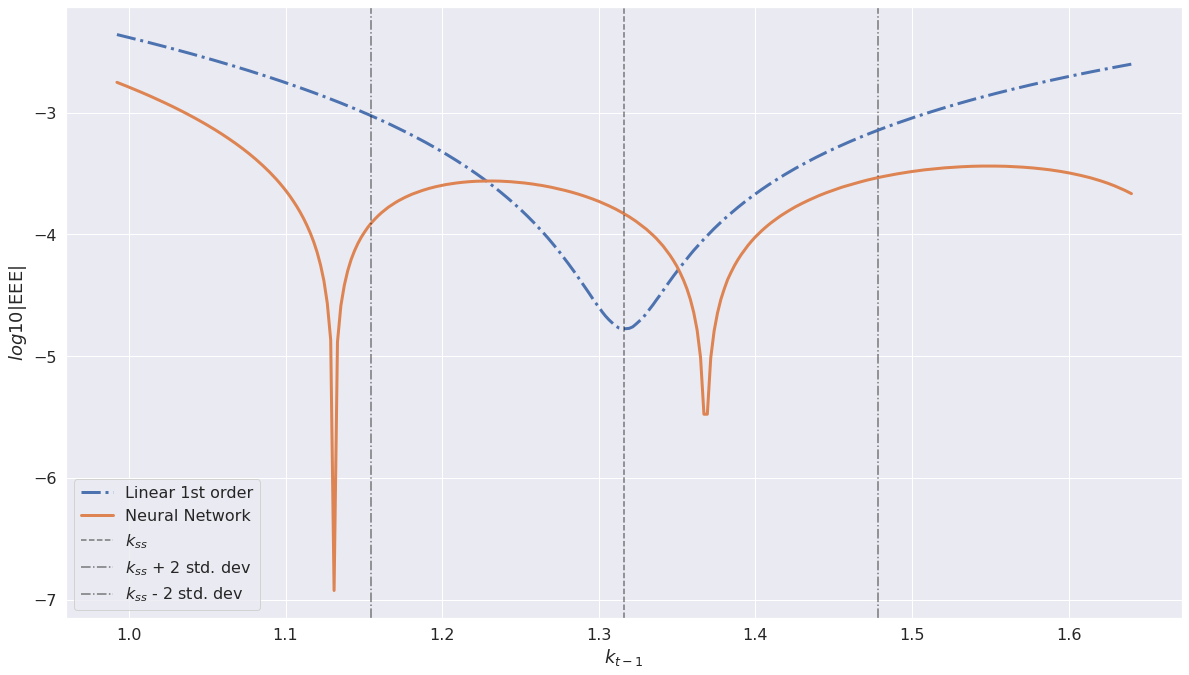

 50%|██████████████████████                      | 5/10 [04:39<04:44, 56.81s/it]

loss: 0.000156, [    0/10000]
loss: 0.000000, [ 1000/10000]
loss: -0.000001, [ 2000/10000]
loss: -0.000001, [ 3000/10000]
loss: 0.000000, [ 4000/10000]
loss: 0.000000, [ 5000/10000]
loss: -0.000003, [ 6000/10000]
loss: 0.000001, [ 7000/10000]
loss: -0.000001, [ 8000/10000]
loss: -0.000001, [ 9000/10000]
--- 68.52335238456726 seconds ---


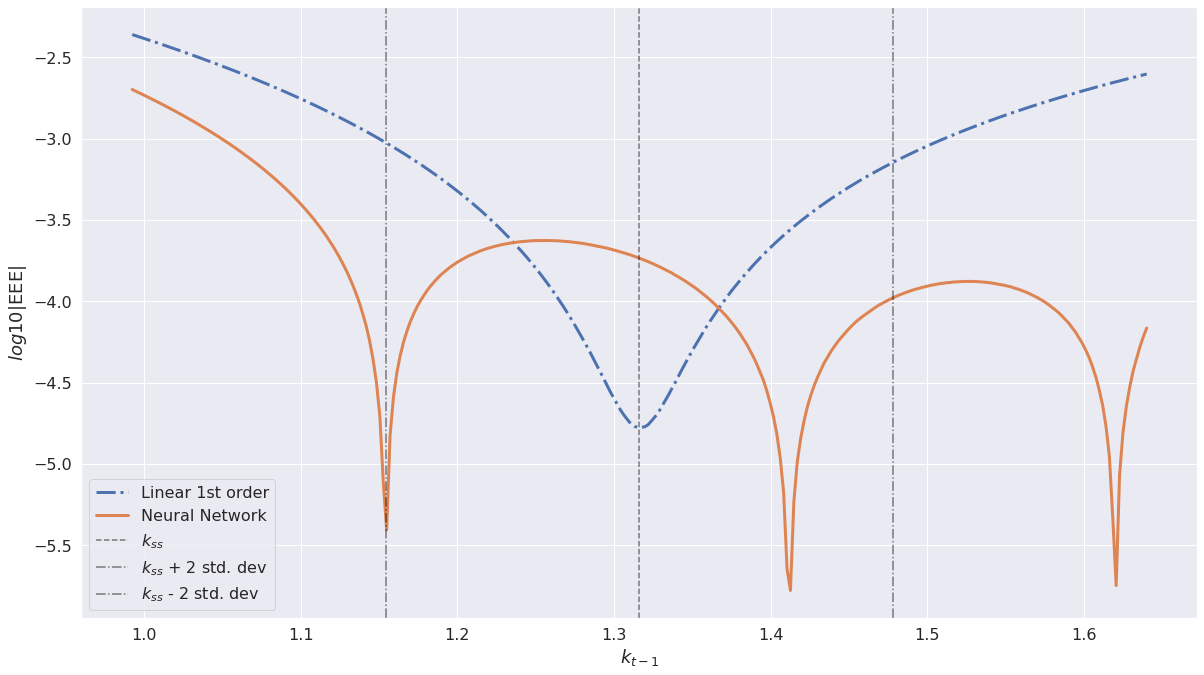

 60%|██████████████████████████▍                 | 6/10 [05:48<04:04, 61.06s/it]

loss: 0.000165, [    0/10000]
loss: 0.000001, [ 1000/10000]
loss: 0.000000, [ 2000/10000]
loss: -0.000001, [ 3000/10000]
loss: 0.000001, [ 4000/10000]
loss: 0.000000, [ 5000/10000]
loss: 0.000000, [ 6000/10000]
loss: -0.000001, [ 7000/10000]
loss: 0.000001, [ 8000/10000]
loss: -0.000001, [ 9000/10000]
--- 64.08234000205994 seconds ---


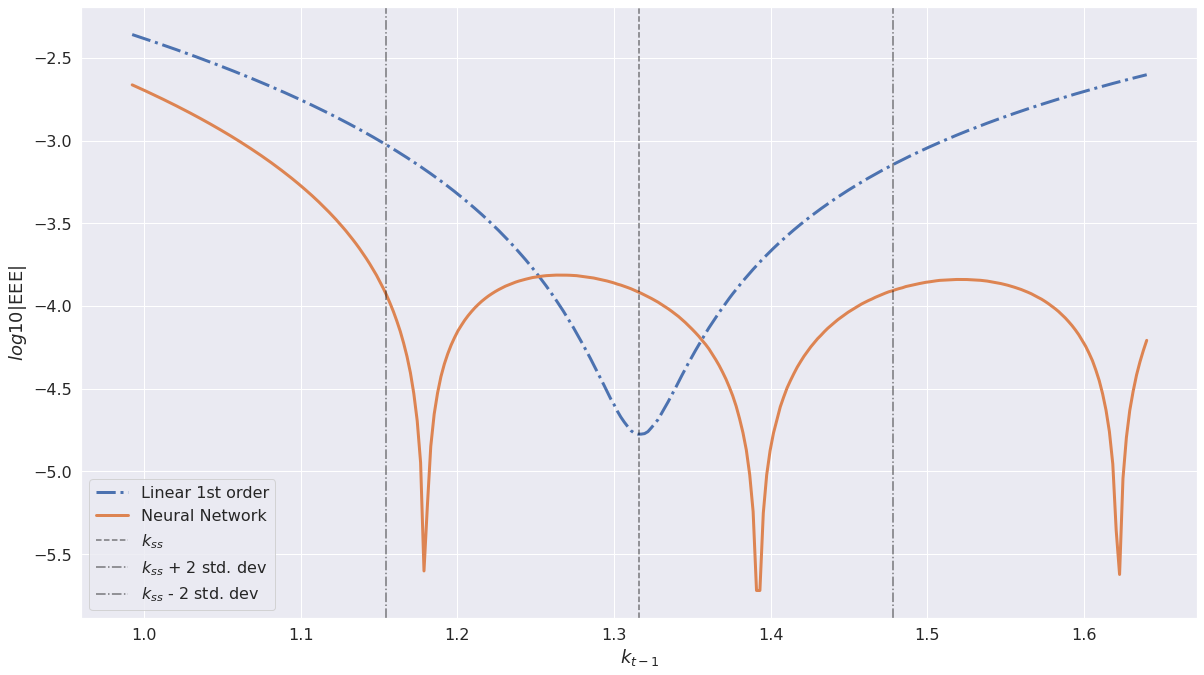

 70%|██████████████████████████████▊             | 7/10 [06:52<03:06, 62.16s/it]

loss: 0.000158, [    0/10000]
loss: -0.000001, [ 1000/10000]
loss: -0.000001, [ 2000/10000]
loss: 0.000003, [ 3000/10000]
loss: -0.000000, [ 4000/10000]
loss: 0.000002, [ 5000/10000]
loss: 0.000001, [ 6000/10000]
loss: -0.000001, [ 7000/10000]
loss: 0.000002, [ 8000/10000]
loss: -0.000001, [ 9000/10000]
--- 58.4440062046051 seconds ---


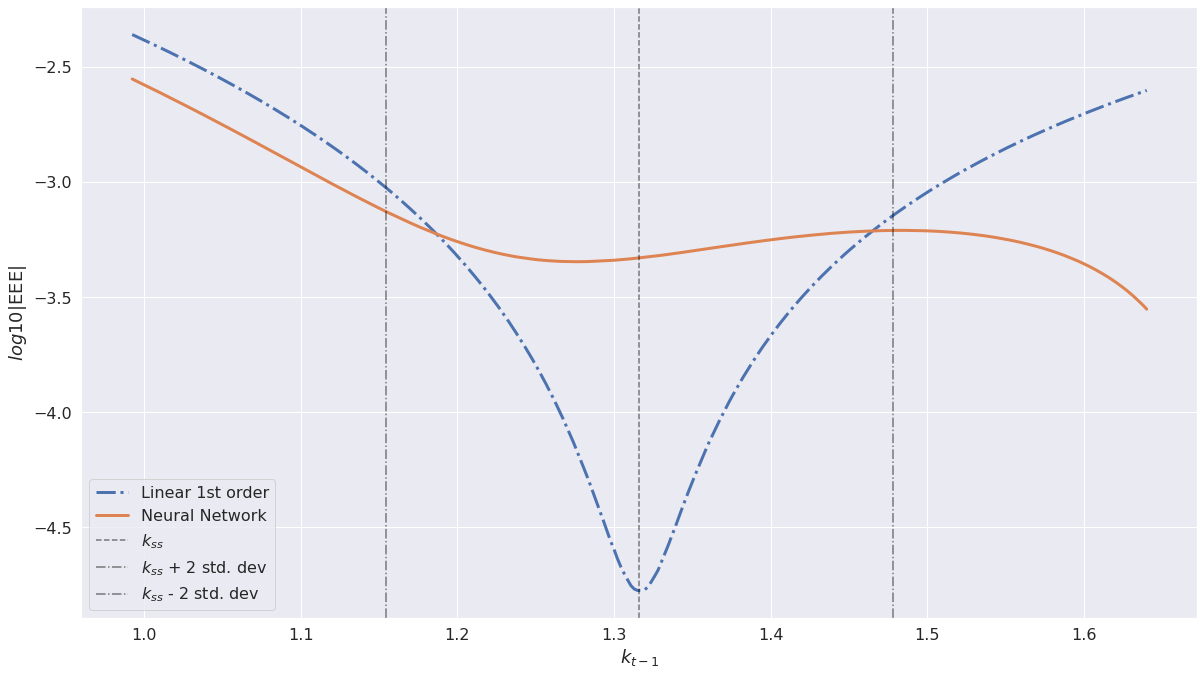

 80%|███████████████████████████████████▏        | 8/10 [07:51<02:02, 61.08s/it]

loss: 0.000163, [    0/10000]
loss: 0.000000, [ 1000/10000]
loss: 0.000001, [ 2000/10000]
loss: -0.000001, [ 3000/10000]
loss: -0.000002, [ 4000/10000]
loss: -0.000001, [ 5000/10000]
loss: 0.000001, [ 6000/10000]
loss: -0.000001, [ 7000/10000]
loss: 0.000001, [ 8000/10000]
loss: 0.000000, [ 9000/10000]
--- 56.44333863258362 seconds ---


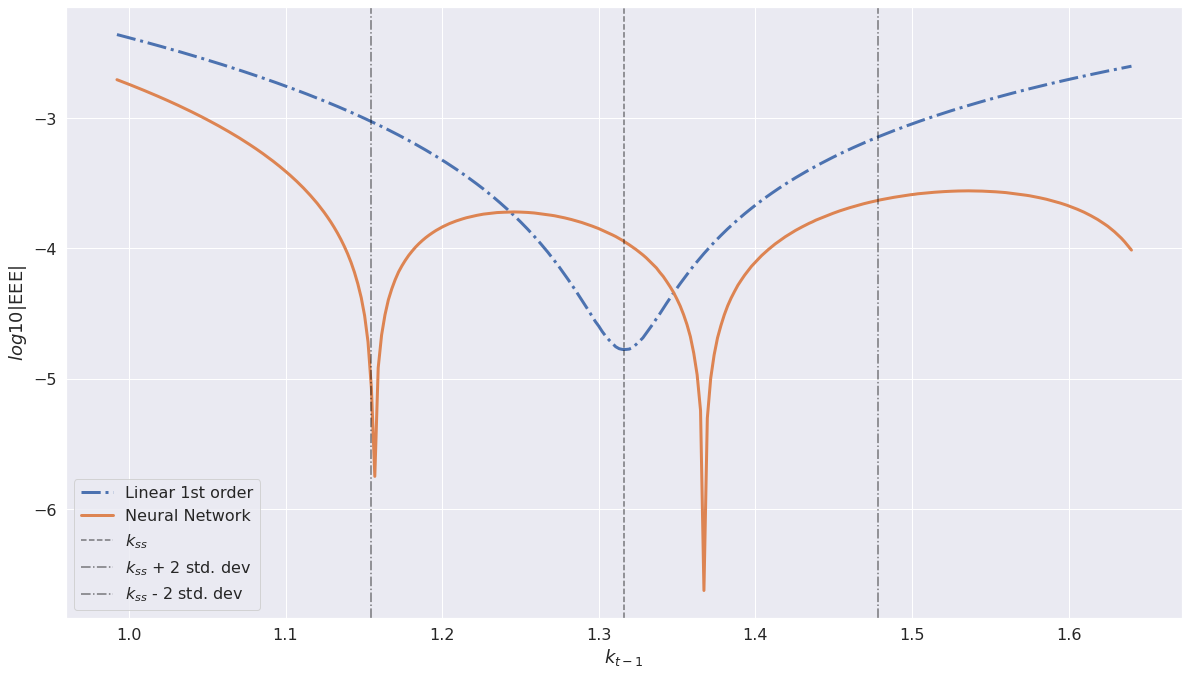

 90%|███████████████████████████████████████▌    | 9/10 [08:48<00:59, 59.74s/it]

loss: 0.000159, [    0/10000]
loss: 0.000001, [ 1000/10000]
loss: 0.000001, [ 2000/10000]
loss: 0.000000, [ 3000/10000]
loss: 0.000002, [ 4000/10000]
loss: 0.000001, [ 5000/10000]
loss: -0.000000, [ 6000/10000]
loss: 0.000001, [ 7000/10000]
loss: 0.000001, [ 8000/10000]
loss: 0.000002, [ 9000/10000]
--- 58.0952832698822 seconds ---


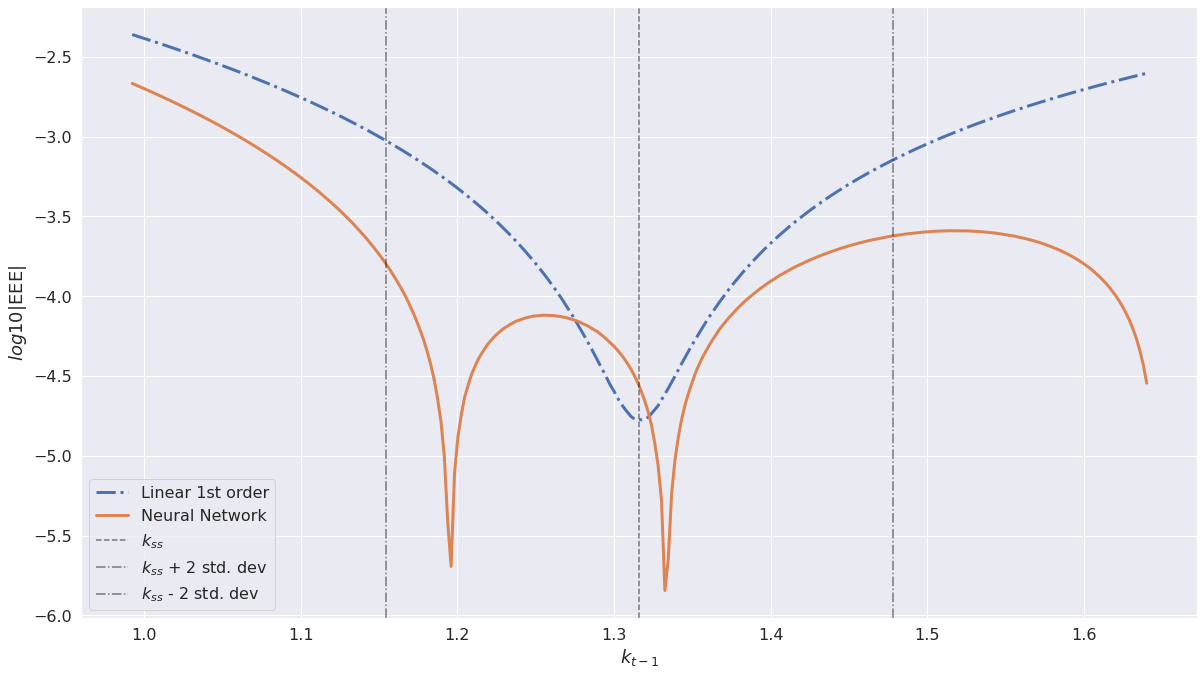

100%|███████████████████████████████████████████| 10/10 [09:46<00:00, 58.69s/it]

0
1
2
3
4
5
6
7
8
9
    k_min_1  a_t  euler_AIO  euler_linear  rep
0  0.992366  1.0   0.002186      0.004369  0.0
1  0.994532  1.0   0.002141      0.004301  0.0
2  0.996698  1.0   0.002097      0.004234  0.0
3  0.998865  1.0   0.002054      0.004168  0.0
4  1.001031  1.0   0.002011      0.004102  0.0
5  1.003198  1.0   0.001969      0.004037  0.0
6  1.005364  1.0   0.001927      0.003973  0.0
7  1.007531  1.0   0.001886      0.003910  0.0
8  1.009697  1.0   0.001845      0.003847  0.0
9  1.011864  1.0   0.001805      0.003784  0.0
      k_min_1  a_t  euler_AIO  euler_linear  rep
290  1.620643  1.0   0.000100      0.002239  9.0
291  1.622809  1.0   0.000093      0.002268  9.0
292  1.624975  1.0   0.000085      0.002296  9.0
293  1.627142  1.0   0.000077      0.002325  9.0
294  1.629308  1.0   0.000070      0.002353  9.0
295  1.631475  1.0   0.000062      0.002382  9.0
296  1.633641  1.0   0.000054      0.002411  9.0
297  1.635808  1.0   0.000046      0.002440  9.0
298  1.637974  1.0   0

In [32]:
# Train x times a neural net. Store EEE.
nb_reps = 10 #10
list_models = []
list_errors_AIO = []
list_dfs = []

if run_analysis_loss == True:
    print("Euler error AIO vs Linear")
    for rep in tqdm(range(0, nb_reps)):
        np.random.seed(int(rep))
        torch.manual_seed(int(rep))
                
        # create a copy of the network
        nn_AIO = copy.deepcopy(nn_AIO_pre_trained)
        nn_AIO.train() #train model

        optimizer = create_optimizer(nn_AIO, params)

        # A LOOP OVER EACH POINT OF THE CURRENT GRID
        # store mean loss by epoch
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
        loss_epochs = torch.zeros(params.nb_epochs)
        # Euler equation error
        list_Euler_err_AIO = [] #store median euler error on grid
        list_Euler_err_AIO_mean = [] #store mean euler error on grid
        list_Euler_err_AIO_i = [] #store index i
        list_Euler_err_AIO_loss = [] #store loss

        freq_loss = 1000 #frequency with which to calculate euler error
        freq_display_loss = 1000
        calculate_euler_error=True #very slow when true

        start_time = time.time()

        for i in range(0, params.nb_epochs):
            optimizer.zero_grad()

            loss = Ξ_torch(nn_AIO, params)
            loss_epochs[[i]] = float(loss.item())

            # Backpropagation
            loss.backward()
            # Clip gradient to prevent potential explosive patterns
            clip_grad_norm_(nn_AIO.parameters(), max_norm=1.0, error_if_nonfinite=False)
            optimizer.step()

            if i % freq_loss == 0: #Monitor Euler error
                if calculate_euler_error == True:
                    # Switch to evaluation mode
                    nn_AIO.eval()
                    with torch.no_grad():
                    # Euler equation error
                        euler_err = evaluate_accuracy_pytorch_Gaussian_frozen(nn_AIO, params, torch.tensor([1e-6]), False, False, distance_f)
                        list_Euler_err_AIO.append(np.median(euler_err)) #median value for euler error 
                        list_Euler_err_AIO_mean.append(np.mean(euler_err))
                        list_Euler_err_AIO_i.append(i)
                        list_Euler_err_AIO_loss.append(loss.item())
                    # Switch back to training mode
                    nn_AIO.train() 

            if i % freq_display_loss == 0: #Monitor the loss
                loss, current = float(loss.item()), i
                print(f"loss: {loss:>7f}, [{current:>5d}/{params.nb_epochs:>5d}]")
            if (i % params.freq_scheduler == 0) & (i != 0) & (params.use_scheduler == True):
                scheduler.step()
                print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

        elasped_time_AIO = time.time() - start_time
        print("--- {} seconds ---".format(elasped_time_AIO ))

        if params.optimizer == "SWA":
            optimizer.swap_swa_sgd()

        # Switch to evaluation mode
        nn_AIO.eval()
        list_models.append(nn_AIO)

        # Evaluate accuracy
        with torch.no_grad():
            # grid for kt-1
            k_min_1 = torch.linspace(params.x_low, params.x_high, nb_points) #add a dimension
            at = torch.ones(len(k_min_1 )) #add a dimension

            # Evaluate accuracy
            ## NN
            euler_AIO = evaluate_accuracy_pytorch_Gaussian(nn_AIO, params, k_min_1, at, tol=torch.tensor([1e-6]), use_linear = False, debug = False)
            list_errors_AIO.append(euler_AIO)
            ## Linear
            euler_linear = evaluate_accuracy_pytorch_Gaussian(nn_AIO, params, k_min_1, at, tol=torch.tensor([1e-6]), use_linear = True, debug = False)

        # Export to .csv results
        df_log10 = pd.DataFrame({'k_min_1': k_min_1, "a_t": at, "euler_AIO": euler_AIO, "euler_linear": euler_linear, "rep": rep*np.ones(len(euler_AIO))}) 
        if save_to_csv == True:
            # Save to csv.
            df_log10.to_csv(output_folder + f"df_log10_{rep}.csv", index=False)
        df_log10.head()
        list_dfs.append(df_log10)

        plt.plot(df_log10["k_min_1"], np.log10(df_log10["euler_linear"]), label='Linear 1st order', linestyle  ="-.", linewidth=3)
        plt.plot(df_log10["k_min_1"], np.log10(df_log10["euler_AIO"]), label='Neural Network', linewidth=3)
        plt.axvline(x = X_SS[params.names.index("K")], linestyle  ="--", label="$k_{ss}$", color="black", alpha=0.5)
        plt.axvline(x = X_SS[params.names.index("K")] + 2*params.stdev_K_linear, linestyle  ="-.", label="$k_{ss}$ + 2 std. dev", color="black", alpha=0.5)
        plt.axvline(x = X_SS[params.names.index("K")] - 2*params.stdev_K_linear, linestyle  ="-.", label="$k_{ss}$ - 2 std. dev", color="black", alpha=0.5)
        plt.xlabel("$k_{t-1}$")
        plt.ylabel("$log10|\mathrm{EEE}|$")
        plt.legend()
        plt.show()
    # Saving merged file
    if save_to_csv == True:
        # Plot average across different training
        df_merged = pd.DataFrame()
        for (index_df, df) in enumerate(list_dfs):
            print(index_df)
            df_merged = pd.concat([df_merged, df])

        print(df_merged.head(10))
        print(df_merged.tail(10))

        df_error_average = df_merged.groupby(["k_min_1"]).mean().reset_index()
        df_error_average["std"] = df_merged.groupby(["k_min_1"]).std().reset_index()["euler_AIO"]
        df_error_average["P10"] = df_merged.groupby(["k_min_1"]).quantile(0.1).reset_index()["euler_AIO"]
        df_error_average["P25"] = df_merged.groupby(["k_min_1"]).quantile(0.25).reset_index()["euler_AIO"]
        df_error_average["P50"] = df_merged.groupby(["k_min_1"]).quantile(0.50).reset_index()["euler_AIO"]
        df_error_average["P75"] = df_merged.groupby(["k_min_1"]).quantile(0.75).reset_index()["euler_AIO"]
        df_error_average["P90"] = df_merged.groupby(["k_min_1"]).quantile(0.9).reset_index()["euler_AIO"]
        print('saving to csv')
        df_error_average.to_csv(output_folder + f"df_error_average.csv", index=False)

In [33]:
output_folder + f"df_error_average.csv"

'/home/julien/Documents/REPOSITORIES/Deep_Learning_DSGE/output/df_error_average.csv'

In [34]:
if read_from_csv == True: #Read from csv
    df_error_average = pd.read_csv(output_folder + f"df_error_average.csv")

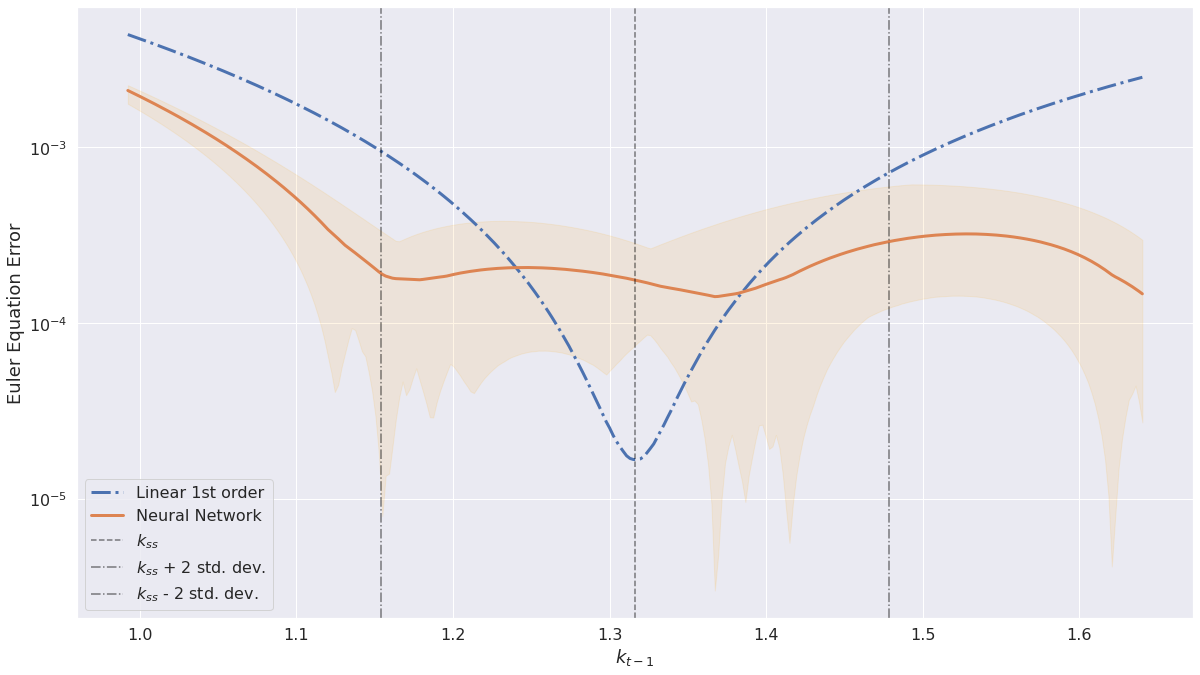

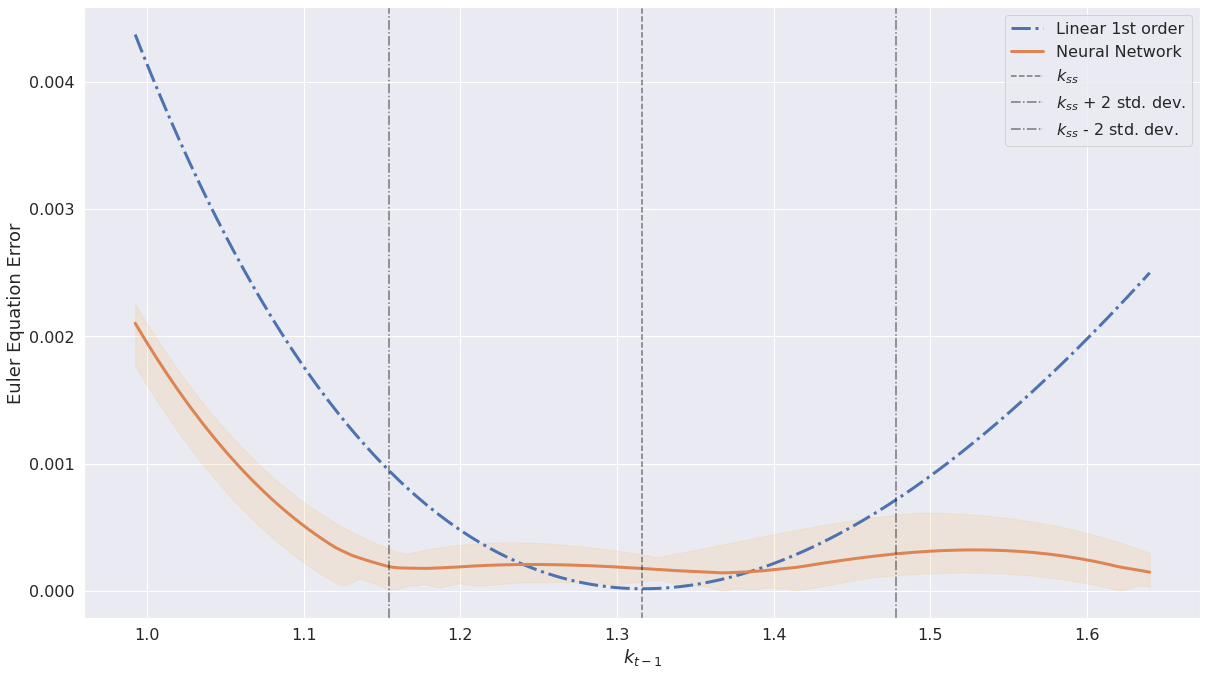

In [35]:
use_log10 = False #Take log10 for y variable
use_log10_yscale_to_try = [True, False] #When true, logscale for y-axis

for use_log10_yscale in use_log10_yscale_to_try:
    if use_log10 == True:
        plt.plot(df_log10["k_min_1"], np.log10(df_log10["euler_linear"]), label='Linear 1st order', linestyle  ="-.", linewidth=3)
        plt.plot(df_error_average["k_min_1"], np.log10(df_error_average["euler_AIO"]), label='Neural Network', linewidth=3)
        plt.fill_between(df_error_average["k_min_1"], np.log10(df_error_average["P10"]), np.log10(df_error_average["P90"]), alpha = 0.1, color="orange")
    else:
        plt.plot(df_log10["k_min_1"], df_log10["euler_linear"], label='Linear 1st order', linestyle  ="-.", linewidth=3)
        plt.plot(df_error_average["k_min_1"], df_error_average["euler_AIO"], label='Neural Network', linewidth=3)
        plt.fill_between(df_error_average["k_min_1"], df_error_average["P10"], df_error_average["P90"], alpha = 0.1, color="orange")

    plt.axvline(x = X_SS[params.names.index("K")], linestyle  ="--", label="$k_{ss}$", color="black", alpha=0.5)
    plt.axvline(x = X_SS[params.names.index("K")] + 2*params.stdev_K_linear, linestyle  ="-.", label="$k_{ss}$ + 2 std. dev.", color="black", alpha=0.5)
    plt.axvline(x = X_SS[params.names.index("K")] - 2*params.stdev_K_linear, linestyle  ="-.", label="$k_{ss}$ - 2 std. dev.", color="black", alpha=0.5)
    plt.xlabel("$k_{t-1}$")
    if use_log10 == True:
        plt.ylabel("$\mathrm{Log10}|\mathrm{EEE}|$")
    else:
        plt.ylabel("Euler Equation Error")
        if use_log10_yscale == True:
            plt.yscale('log')
    plt.legend()
    plt.savefig(output_folder + f"Euler_error_AIO_and_linearized_several_runs_{use_log10_yscale}.png", dpi=600)
    plt.savefig(output_folder + f"Euler_error_AIO_and_linearized_several_runs_{use_log10_yscale}.pdf", dpi=600)
    plt.show()

## V. Impact of hyperparameters on DL solution

So far, all we the previous experiments were done while keeping hyperparameters unchanged. Now, we change the hyperparameters to see how they impact the quality of the DL solution. We change:

* the number of hidden layer 
* the number of nodes in each hidden layer
* the type of activation function:
* the optimizer to use
* the learning rate
* the number of independent draws use to approximate the expectation operator

### V.A. Changing all hyperparameters

We try all the different combinations of hyperparameters. 

In [36]:
# To store final results
list_nb_hidden_layers = [] #number of hidden layers
list_nb_nodes = [] #number of nodes in hidden layer
list_elapsed_time = [] #elasped time (seconds)
list_T = [] #choice of number of draws for AIO
list_optimizers = [] #Adam versus GD
list_lr = [] #learning rate
list_stdev_TFP = []#stdev TFP
list_act_function = [] #type of activation function
list_dropout_rate = [] #List of dropout rates

# Store final values
list_losses_final = [] #Store the losses during training
list_mean_euler_error_final = [] #mean euler error
list_median_euler_error_final = [] #median euler error
list_max_euler_error_final = [] #max euler error
list_stdev_euler_error_final = [] #stdev euler error
list_elapsed_time_final = [] #elapsed time (in seconds)

# To store results during traning
## every x iterations
list_list_losses_i = [] #Store the losses during training
list_list_mean_euler_error = []  #median
list_list_median_euler_error = []  #mean
list_list_max_euler_error = [] #max euler error
list_list_stdev_euler_error = [] #stdev euler error
list_list_index_i = [] #index 
list_Euler_err_AIO_loss_i = []

## ever iterations
list_list_losses = [] #loss
list_list_computing_time = []  #execution time (sec)

# Default
list_nb_hidden_layers_to_try = [1, 2]
list_nodes_to_try = [4, 16, 32]
list_activ_func_to_try = [nn.Tanh(), nn.Sigmoid(), nn.ReLU()]
list_optim_to_try = ["SGD", "Adam"]
list_lr_to_try = [1e-1, 1e-2, 1e-3, 1e-4]    # ADAM
list_T_to_try = [1, 10, 100, 1000] #[2, 100, 500, 1000]
list_std_to_try = [std_TFP_yearly] #Std dev shocks
list_dropout_rate_to_try = [0.0] #Probability to zero an element

# DEBUG
#list_nb_hidden_layers_to_try = [1]
#list_nodes_to_try = [16]
#list_activ_func_to_try = [nn.Tanh()]
#list_optim_to_try = ["SGD"]
#list_lr_to_try = [100, 10, 1, 1e-1]    # ADAM
#list_T_to_try = [1, 10, 100, 1000] #[2, 100, 500, 1000]
#list_std_to_try = [std_TFP_yearly] #Std dev shocks
#list_dropout_rate_to_try = [0.0]

# Test, to see if all the hyperparameter choices work
nn_AIO = NeuralNetwork(nb_nodes, nn.Tanh(), 1, 0.0).to(device)
print(nn_AIO)

# Loop over number nodes
index = 0
for (index_hidden_layers, nb_hidden_layers) in enumerate(list_nb_hidden_layers_to_try):
    for (index_node, nb_nodes_chosen) in enumerate(list_nodes_to_try):
    # Loop over activation functions
        for (index_act_f, act_f_chosen) in enumerate(list_activ_func_to_try):
            # Loop over optimization
            for (index_opt, optimizer_chosen) in enumerate(list_optim_to_try):
                # Loop over learning rates
                for (index_lr, lr_chosen) in enumerate(list_lr_to_try): 
                    # Loop over number of draws for AIO
                    for (index_lr, T_chosen) in enumerate(list_T_to_try): 
                        # Loop over stdev TFP
                        for (index_stdev_TFP, stdev_TFP_chosen) in enumerate(list_std_to_try): 
                            for (index_dropout_rate, dropout_rate_chosen) in enumerate(list_dropout_rate_to_try): 
                                index+=1
                                # Initialize model
                                nn_AIO = NeuralNetwork(nb_nodes_chosen, act_f_chosen, nb_hidden_layers, dropout_rate_chosen).to(device)
                                state_vec = torch.column_stack([torch.ones(10), torch.ones(10)])
                                vals = model_normalized(state_vec, nn_AIO, params)
print(vals)                            
print(index)                
time_per_iter = 40 #Average seconds per training. This depends on your machine
# Give an estimate of the running time
print("Expected time (hours): {}".format((index*time_per_iter)/3600))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): Tanh()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): Dropout(p=0.0, inplace=False)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
(tensor([[0.2702806592],
        [0.2702806592],
        [0.2702806592],
        [0.2702806592],
        [0.2702806592],
        [0.2702806592],
        [0.2702806592],
        [0.2702806592],
        [0.2702806592],
        [0.2702806592]], grad_fn=<MulBackward0>), tensor([[0.4069110155],
        [0.4069110155],
        [0.4069110155],
        [0.4069110155],
        [0.4069110155],
        [0.4069110155],
        [0.4069110155],
        [0.4069110155],
        [0.4069110155],
        [0.4069110155]], grad_fn=<MulBackward0>))
576
Expected time (hours): 6.4


In [37]:
# Loop over number nodes
max_index = 0
for (index_hidden_layers, nb_hidden_layers) in enumerate(list_nb_hidden_layers_to_try):
    for (index_node, nb_nodes_chosen) in enumerate(list_nodes_to_try):
    # Loop over activation functions
        for (index_act_f, act_f_chosen) in enumerate(list_activ_func_to_try):
            # Loop over optimization
            for (index_opt, optimizer_chosen) in enumerate(list_optim_to_try):
                # Loop over learning rates
                for (index_lr, lr_chosen) in enumerate(list_lr_to_try): 
                    # Loop over number of draws for AIO
                    for (index_lr, T_chosen) in enumerate(list_T_to_try): 
                        # Loop over stdev TFP
                        for (index_stdev_TFP, stdev_TFP_chosen) in enumerate(list_std_to_try): 
                            for (index_dropout_rate, dropout_rate_chosen) in enumerate(list_dropout_rate_to_try):
                                max_index+=1

print(max_index)

576


In [38]:
#train the model, changing hyperparameters
#Can be very slow
if run_benchmark == True: 
    print("Starting benchmark hyperparams")

    start_time_all = time.time()
    seed=int(nb_extension)
    nb_epochs_chosen = 5000 #number of gradient descent steps
    freq_loss = 1000 #calculate Euler error error x iterations (slow)
    order_gauss_chosen = 5 #order quadrature for EEE calculation
    pretrain_model = True #Pre-train the model before starting real training loop
    index = 0
    # Loop over number of nodes
    for (index_node, nb_nodes_chosen) in tqdm(enumerate(list_nodes_to_try)):
        # Loop for number of hidden layers
        for (index_hidden_layers, nb_hidden_layers) in enumerate(list_nb_hidden_layers_to_try):
        # Loop over activation functions
            for (index_act_f, act_f_chosen) in enumerate(list_activ_func_to_try):
                # Loop over optimization
                for (index_opt, optimizer_chosen) in enumerate(list_optim_to_try):
                    # Loop over learning rates
                    for (index_lr, lr_chosen) in enumerate(list_lr_to_try): 
                        # Loop over number of draws for AIO
                        for (index_lr, T_chosen) in enumerate(list_T_to_try): 
                            # Loop over stdev TFP
                            for (index_stdev_TFP, std_TFP_chosen) in enumerate(list_std_to_try): 
                                # Choice of dropout rate (regularization)
                                for (index_dropout_rate, dropout_rate_chosen) in enumerate(list_dropout_rate_to_try):
                                    # Keep track of index
                                    index+=1
                                    # debug
                                    #if index >= 3:
                                    #    break 
                                    # Initialize model
                                    np.random.seed(seed)
                                    torch.manual_seed(seed)
                                    # Initialize neural network
                                    nn_AIO = NeuralNetwork(nb_nodes_chosen, act_f_chosen, nb_hidden_layers, dropout_rate_chosen).to(device)
                                    # Params
                                    params = MyParams(T_chosen, lr_chosen, nb_epochs_chosen, order_gauss_chosen, use_Sobol_chosen, std_TFP_chosen, delta_chosen, optimizer_chosen)
                                    print("----------------------------------------")
                                    print("Iteration: {} / {}".format(index, max_index))
                                    print("nb nodes: {}".format(nb_nodes_chosen))
                                    print("nb hidden layers: {}".format(nb_hidden_layers))
                                    print("dropout: {}".format(dropout_rate_chosen))
                                    print("act. f.: {}".format(act_f_chosen))
                                    print("T: {}".format(params.T))
                                    print("lr: {}".format(params.lr))
                                    print("optimizer: {}".format(params.optimizer))
                                    print("std_TFP: {}".format(params.σ_e))
                                    print("delta: {}".format(params.delta))
                                    #------------------------------------------
                                    # Pre-training the model
                                    #------------------------------------------
                                    nn_AIO.train()
                                    if pretrain_model == True:
                                        optimizer = create_optimizer(nn_AIO, params)

                                        for i in range(0, params.nb_epochs):
                                            optimizer.zero_grad()
                                            # Loss function for initialization
                                            loss = Ξ_torch_init(nn_AIO, params)

                                            # Backpropagation
                                            loss.backward()
                                            optimizer.step()
                                            if i == params.nb_epochs - 1:
                                                print(f"Loss pre-training: {loss.item()}")
                                    #------------------------------------------
                                    # Training loop
                                    #------------------------------------------
                                    optimizer = create_optimizer(nn_AIO, params)

                                    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
                                    loss_epochs = torch.zeros(params.nb_epochs)
                                    list_computing_time = torch.zeros(params.nb_epochs)

                                    list_Euler_err_AIO_median = [] #store median euler error on grid
                                    list_Euler_err_AIO_mean = [] #store mean euler error on grid
                                    list_Euler_err_AIO_max = [] #maximum error
                                    list_Euler_err_AIO_stdev = [] #stdev
                                    list_Euler_err_AIO_i = [] #store index i
                                    list_Euler_err_AIO_loss_i = [] #store loss

                                    print("Training model")
                                    start_time = time.time()
                                    # Training loop
                                    for i in range(0, params.nb_epochs):
                                        optimizer.zero_grad()
                                        loss = Ξ_torch(nn_AIO, params)
                                        loss_epochs[i] = float(loss.item())
                                        # store execution time (sec)
                                        list_computing_time[i] = time.time() - start_time

                                        # Backpropagation
                                        loss.backward()
                                        # Clip gradient to prevent potential explosive patterns
                                        clip_grad_norm_(nn_AIO.parameters(), max_norm=1.0, error_if_nonfinite=False)
                                        optimizer.step()

                                        if i % freq_loss == 0: #Monitor Euler error
                                            # Switch to evaluation mode
                                            nn_AIO.eval()
                                            with torch.no_grad():
                                            # Euler equation error
                                                euler_err = evaluate_accuracy_pytorch_Gaussian_frozen(nn_AIO, params, torch.tensor([1e-6]), False, False, distance_f)
                                                med_euler = np.median(euler_err)
                                                mean_euler = np.mean(euler_err)
                                                max_euler = np.max(euler_err)
                                                stdev_euler = np.std(euler_err)
                                                list_Euler_err_AIO_median.append(med_euler ) #median value for euler error + FOC error labor
                                                list_Euler_err_AIO_mean.append(mean_euler)
                                                list_Euler_err_AIO_max.append(max_euler)
                                                list_Euler_err_AIO_stdev.append(stdev_euler)
                                                list_Euler_err_AIO_i.append(i)
                                                list_Euler_err_AIO_loss_i.append(loss.item())
                                            #print(f"mean euler error: {mean_euler}")
                                            # Switch back to training mode
                                            nn_AIO.train() 
                                        if i % 1000 == 0: #Monitor the loss
                                            loss, current = float(loss.item()), i
                                            print(f"loss: {loss:>7f}, [{current:>5d}/{params.nb_epochs:>5d}]")
                                        if (i % params.freq_scheduler == 0) & (i != 0) & (params.use_scheduler == True):
                                            scheduler.step()
                                            #print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

                                    elasped_time_AIO = time.time() - start_time
                                    elasped_time_all = time.time() - start_time_all
                                    print(f'Elapsed time loop: {elasped_time_AIO } sec.')
                                    print(f'Elapsed time all: {elasped_time_all/60} min.')

                                    ## Store results every iterations
                                    #list_list_losses.append(loss_epochs)
                                    #list_list_computing_time.append(list_computing_time)

                                    if params.optimizer == "SWA":
                                        optimizer.swap_swa_sgd()

                                    # Store final values Euler equation error
                                    # Accuracy
                                    nn_AIO.eval() #eval mode
                                    with torch.no_grad():
                                        euler_err = evaluate_accuracy_pytorch_Gaussian_frozen(nn_AIO, params, torch.tensor([1e-6]), False, False, distance_f)
                                        med_euler = np.median(euler_err)
                                        mean_euler = np.mean(euler_err)
                                        max_euler = np.max(euler_err)
                                        stdev_euler = np.std(euler_err)

                                    # Params
                                    list_nb_hidden_layers.append(nb_hidden_layers)
                                    list_nb_nodes.append(nb_nodes_chosen)
                                    list_act_function.append(index_act_f)
                                    list_optimizers.append(optimizer_chosen) #Adam versus GD
                                    list_lr.append(lr_chosen) #learning rate
                                    list_T.append(T_chosen) #choice of number of draws for AIO
                                    list_stdev_TFP.append(std_TFP_chosen) # stdev shocks
                                    list_dropout_rate.append(dropout_rate_chosen) #dropout rate

                                    # Results                                
                                    ## Intermediate results
                                    ### Every iterations
                                    list_list_losses.append(loss_epochs)
                                    list_list_computing_time.append(list_computing_time)  #execution time (sec)

                                    ### Every x iterations
                                    list_list_mean_euler_error.append(list_Euler_err_AIO_mean)
                                    list_list_median_euler_error.append(list_Euler_err_AIO_median)
                                    list_list_max_euler_error.append(list_Euler_err_AIO_max)
                                    list_list_stdev_euler_error.append(list_Euler_err_AIO_stdev)
                                    list_list_index_i.append(list_Euler_err_AIO_i)
                                    list_list_losses_i.append(list_Euler_err_AIO_loss_i)

                                    ## Final results
                                    list_losses_final.append(float(loss.item())) #Store the losses during training
                                    list_mean_euler_error_final.append(mean_euler)#mean euler error
                                    list_median_euler_error_final.append(med_euler) #median euler error
                                    list_max_euler_error_final.append(max_euler)
                                    list_stdev_euler_error_final.append(stdev_euler)
                                    list_elapsed_time_final.append(elasped_time_AIO) #elapsed time (in seconds)
    # Save data
    # Calculate: final losses, final variances, final error
    print("Creating df")
    ## Final results
    list_seed_nb = np.repeat(seed, len(list_nb_hidden_layers))
    list_k = np.arange(0, len(list_nb_hidden_layers))

    df_hyperparameters = pd.DataFrame({
                        'seed_nb': list_seed_nb,
                        'nb_hidden_layers': list_nb_hidden_layers,
                        'nb_nodes': list_nb_nodes,
                        'activation_function': list_act_function,
                        'optimizer': list_optimizers,
                        'lr': list_lr,
                        'T': list_T,
                        'stdev_TFP': list_stdev_TFP,
                        'elapsed_time_sec': list_elapsed_time_final,
                        'final_loss': list_losses_final,
                        'mean_perc_abs_error': list_mean_euler_error_final,
                        'median_perc_abs_error':list_median_euler_error_final,
                        'max_perc_abs_error': list_max_euler_error_final,
                        'std_perc_abs_error': list_stdev_euler_error_final,
                        'dropout_rate': list_dropout_rate,
                        'index_hyperparam': list_k})

    # Give a name to activation functions
    df_hyperparameters['activation_function_name'] = ""
    df_hyperparameters.loc[df_hyperparameters['activation_function'] == 0, 'activation_function_name'] = "Tanh" 
    df_hyperparameters.loc[df_hyperparameters['activation_function'] == 1, 'activation_function_name'] = "Sigmoid"
    df_hyperparameters.loc[df_hyperparameters['activation_function'] == 2, 'activation_function_name'] = "ReLU"
    print(df_hyperparameters.head(10))
    
    ## Result for each gradient descent step
    iteration_steps = np.arange(0, params.nb_epochs)
    iteration_steps = np.tile(iteration_steps, len(list_list_computing_time))
    list_seed_nb = np.repeat(seed, len(iteration_steps ))
    # to keep track of different hyperparams
    list_k = np.repeat(np.arange(0, len(list_list_computing_time)), params.nb_epochs) 

    df_losses = pd.DataFrame({
                        'seed_nb': list_seed_nb,
                        'iteration': iteration_steps,
                        'computing_time': numpy_flat(list_list_computing_time),
                        'loss': numpy_flat(list_list_losses),
                        'index_hyperparam': list_k})

    print(df_losses.head(5))
    
    ## Result for every x gradient descent step
    list_seed_nb = np.repeat(seed, len(numpy_flat(list_list_mean_euler_error)))

    df_losses_every_x = pd.DataFrame({
                        'seed_nb': list_seed_nb,
                        'mean_euler_error': numpy_flat(list_list_mean_euler_error),
                        'median_euler_error': numpy_flat(list_list_median_euler_error),
                        'max_euler_error': numpy_flat(list_list_max_euler_error),
                        'stdev_euler_error': numpy_flat(list_list_stdev_euler_error),
                        'iteration_index': numpy_flat(list_list_index_i),
                        'loss': numpy_flat(list_list_losses_i)})

    print(df_losses_every_x.head(5))

    if save_to_csv == True:
        print("Saving df to diks")
        # Save to csv.
        df_hyperparameters.to_csv(output_folder + 'df_hyperparameters.csv', index=False)
        # Save to csv.
        df_losses.to_csv(output_folder + 'df_losses.csv', index=False)
        # Save to csv.
        df_losses_every_x.to_csv(output_folder + 'df_losses_every_x.csv', index=False)

#### Plots

For the paper, we use **ggplot2** and **R** to create the figures, loading the file df_hyperparameters.csv and df_losses.csv we have just created above.

#### Closing session

In [39]:
# If on Google Colab, copy files to GDrive
# Copy to drive
if on_Colab==True:

    path = f"/gdrive/My Drive/{output_extension}"
    # Create folder if does not exist:
    if not os.path.exists(path):
      # If it doesn't exist, create it
      os.mkdir(path)

    ## A. Save to Grdive
    # Compress to zip
    !zip -r /content/file.zip /content/output

    shutil.copy("/content/file.zip", f"{path}/file.zip")

    drive.flush_and_unmount()
    print('All changes made in this colab session should now be visible in Drive.')

# If on Colab, close the current session
disconnect_when_done = True
if on_Colab==True:
    # Wait 2 minutes
    time.sleep(120)
    ## Close session
    from google.colab import runtime
    if disconnect_when_done==True:
      print("Closing runtime")
      runtime.unassign()
    else:
      print("Still running session.")

### V.B. Changing some hyperparameters

Instead of trying all the combinations of hyperparameters, which is very time consuming, we can change just one hyperparameter.
For instance, let's see how the number of independent draws used to approximate the expectation operator in the loss function affects the accuracy of the solution. 

In [40]:
# To store final results
distance_f = lambda x: torch.abs(x) #can be torch.abs or torch.sqrt(x**2)

list_nb_hidden_layers = [] #number of hidden layers
list_nb_nodes = [] #number of nodes in hidden layer
list_elapsed_time = [] #elasped time (seconds)
list_T = [] #choice of number of draws for AIO
list_optimizers = [] #Adam versus GD
list_lr = [] #learning rate
list_stdev_TFP = []#stdev TFP
list_act_function = [] #type of activation function
list_dropout_rate = [] #List of dropout rates

# Store final values
list_losses_final = [] #Store the losses during training
list_mean_euler_error_final = [] #mean euler error
list_median_euler_error_final = [] #median euler error
list_max_euler_error_final = [] #max euler error
list_stdev_euler_error_final = [] #stdev euler error
list_elapsed_time_final = [] #elapsed time (in seconds)

# To store results during traning
## every x iterations
list_list_losses_i = [] #Store the losses during training
list_list_mean_euler_error = []  #median
list_list_median_euler_error = []  #mean
list_list_max_euler_error = [] #max euler error
list_list_stdev_euler_error = [] #stdev euler error
list_list_index_i = [] #index 
list_Euler_err_AIO_loss_i = []

## ever iterations
list_list_losses = [] #loss
list_list_computing_time = []  #execution time (sec)

list_nb_hidden_layers_to_try = [1]
list_nodes_to_try = [32]
list_activ_func_to_try = [nn.ReLU()]
list_optim_to_try = ["Adam"]
list_lr_to_try = [1e-3]    # ADAM
list_T_to_try = [1, 10, 100, 1000, 5000]
list_std_to_try = [std_TFP_yearly] #Std dev shocks
list_dropout_rate_to_try = [0.0]

nn_AIO = NeuralNetwork(nb_nodes, nn.Tanh(), 1, 0.0).to(device)
print(nn_AIO)

# Loop over number nodes
index = 0
for (index_hidden_layers, nb_hidden_layers) in enumerate(list_nb_hidden_layers_to_try):
    for (index_node, nb_nodes_chosen) in enumerate(list_nodes_to_try):
    # Loop over activation functions
        for (index_act_f, act_f_chosen) in enumerate(list_activ_func_to_try):
            # Loop over optimization
            for (index_opt, optimizer_chosen) in enumerate(list_optim_to_try):
                # Loop over learning rates
                for (index_lr, lr_chosen) in enumerate(list_lr_to_try): 
                    # Loop over number of draws for AIO
                    for (index_lr, T_chosen) in enumerate(list_T_to_try): 
                        # Loop over stdev TFP
                        for (index_stdev_TFP, stdev_TFP_chosen) in enumerate(list_std_to_try): 
                            for (index_dropout_rate, dropout_rate_chosen) in enumerate(list_dropout_rate_to_try): 
                                index+=1
                                # Initialize model
                                nn_AIO = NeuralNetwork(nb_nodes_chosen, act_f_chosen, nb_hidden_layers, dropout_rate_chosen).to(device)
                                state_vec = torch.column_stack([torch.ones(10), torch.ones(10)])
                                vals = model_normalized(state_vec, nn_AIO, params)

max_index = index #store nb of combinations

if run_limited_benchmark == True: #train 1 time the model, changing hyperparameters
    print("Starting benchmark hyperparams")

    start_time_all = time.time()
    seed=int(nb_extension)
    nb_epochs_chosen = 5000 #number of gradient descent steps
    freq_loss = 1000 #calculate Euler error error x iterations (slow)
    order_gauss_chosen = 5 #Revelant when calculation
    pretrain_model = False #Pre-train the model before starting real training loop
    index = 0
    # Loop over number of nodes
    for (index_node, nb_nodes_chosen) in tqdm(enumerate(list_nodes_to_try)):
        # Loop for number of hidden layers
        for (index_hidden_layers, nb_hidden_layers) in enumerate(list_nb_hidden_layers_to_try):
        # Loop over activation functions
            for (index_act_f, act_f_chosen) in enumerate(list_activ_func_to_try):
                # Loop over optimization
                for (index_opt, optimizer_chosen) in enumerate(list_optim_to_try):
                    # Loop over learning rates
                    for (index_lr, lr_chosen) in enumerate(list_lr_to_try): 
                        # Loop over number of draws for AIO
                        for (index_lr, T_chosen) in enumerate(list_T_to_try): 
                            # Loop over stdev TFP
                            for (index_stdev_TFP, std_TFP_chosen) in enumerate(list_std_to_try): 
                                # Choice of dropout rate (regularization)
                                for (index_dropout_rate, dropout_rate_chosen) in enumerate(list_dropout_rate_to_try):
                                    # Keep track of index
                                    index+=1
                                    # debug
                                    #if index >= 3:
                                    #    break 
                                    # Initialize model
                                    np.random.seed(seed)
                                    torch.manual_seed(seed)
                                    # Initialize neural network
                                    nn_AIO = NeuralNetwork(nb_nodes_chosen, act_f_chosen, nb_hidden_layers, dropout_rate_chosen).to(device)
                                    # Params
                                    params = MyParams(T_chosen, lr_chosen, nb_epochs_chosen, order_gauss_chosen, use_Sobol_chosen, std_TFP_chosen, delta_chosen, optimizer_chosen)
                                    print("----------------------------------------")
                                    print("Iteration: {} / {}".format(index, max_index))
                                    print("nb nodes: {}".format(nb_nodes_chosen))
                                    print("nb hidden layers: {}".format(nb_hidden_layers))
                                    print("dropout: {}".format(dropout_rate_chosen))
                                    print("act. f.: {}".format(act_f_chosen))
                                    print("T: {}".format(params.T))
                                    print("lr: {}".format(params.lr))
                                    print("optimizer: {}".format(params.optimizer))
                                    print("std_TFP: {}".format(params.σ_e))
                                    print("delta: {}".format(params.delta))
                                    #------------------------------------------
                                    # Pre-training the model
                                    #------------------------------------------
                                    nn_AIO.train()
                                    if pretrain_model == True:
                                        optimizer = create_optimizer(nn_AIO, params)

                                        for i in range(0, params.nb_epochs):
                                            optimizer.zero_grad()
                                            # Loss function for initialization
                                            loss = Ξ_torch_init(nn_AIO, params)

                                            # Backpropagation
                                            loss.backward()
                                            optimizer.step()
                                            if i == params.nb_epochs - 1:
                                                print(f"Loss pre-training: {loss.item()}")
                                    #------------------------------------------
                                    # Training loop
                                    #------------------------------------------
                                    optimizer = create_optimizer(nn_AIO, params)

                                    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params.freq_gamma)
                                    loss_epochs = torch.zeros(params.nb_epochs)
                                    list_computing_time = torch.zeros(params.nb_epochs)

                                    list_Euler_err_AIO_median = [] #store median euler error on grid
                                    list_Euler_err_AIO_mean = [] #store mean euler error on grid
                                    list_Euler_err_AIO_max = [] #maximum error
                                    list_Euler_err_AIO_stdev = [] #stdev
                                    list_Euler_err_AIO_i = [] #store index i
                                    list_Euler_err_AIO_loss_i = [] #store loss

                                    print("Training model")
                                    start_time = time.time()
                                    # Training loop
                                    for i in range(0, params.nb_epochs):
                                        optimizer.zero_grad()
                                        loss = Ξ_torch(nn_AIO, params)
                                        loss_epochs[i] = float(loss.item())
                                        # store execution time (sec)
                                        list_computing_time[i] = time.time() - start_time

                                        # Backpropagation
                                        loss.backward()
                                        # Clip gradient to prevent potential explosive patterns
                                        clip_grad_norm_(nn_AIO.parameters(), max_norm=1.0, error_if_nonfinite=False)
                                        optimizer.step()

                                        if i % freq_loss == 0: #Monitor Euler error
                                            # Switch to evaluation mode
                                            nn_AIO.eval()
                                            with torch.no_grad():
                                                # Euler equation error
                                                #euler_err = evaluate_accuracy_pytorch_Gaussian_frozen(nn_AIO, params, torch.tensor([1e-6]), False, False, distance_f)
                                                state_vec = generate_state_vec(1000, params)
                                                euler_err = evaluate_accuracy_pytorch_Gaussian(nn_AIO, params, state_vec[:, 0], state_vec[:, 1], torch.tensor([1e-6]), False, False, distance_f)
                                                med_euler = np.median(euler_err)
                                                mean_euler = np.mean(euler_err)
                                                max_euler = np.max(euler_err)
                                                stdev_euler = np.std(euler_err)
                                                list_Euler_err_AIO_median.append(med_euler ) #median value for euler error + FOC error labor
                                                list_Euler_err_AIO_mean.append(mean_euler)
                                                list_Euler_err_AIO_max.append(max_euler)
                                                list_Euler_err_AIO_stdev.append(stdev_euler)
                                                list_Euler_err_AIO_i.append(i)
                                                list_Euler_err_AIO_loss_i.append(loss.item())
                                            #print(f"mean euler error: {mean_euler}")
                                            # Switch back to training mode
                                            nn_AIO.train() 
                                        if i % 1000 == 0: #Monitor the loss
                                            loss, current = float(loss.item()), i
                                            print(f"loss: {loss:>7f}, [{current:>5d}/{params.nb_epochs:>5d}]")
                                        if (i % params.freq_scheduler == 0) & (i != 0) & (params.use_scheduler == True):
                                            scheduler.step()
                                            #print("i : {}. Decreasing learning rate: {}".format(i, scheduler.get_last_lr()))

                                    elasped_time_AIO = time.time() - start_time
                                    elasped_time_all = time.time() - start_time_all
                                    print(f'Elapsed time loop: {elasped_time_AIO } sec.')
                                    print(f'Elapsed time all: {elasped_time_all/60} min.')

                                    if params.optimizer == "SWA":
                                        optimizer.swap_swa_sgd()

                                    # Store final values Euler equation error
                                    # Accuracy
                                    nn_AIO.eval() #eval mode
                                    with torch.no_grad():
                                        ## New draws
                                        #state_vec = generate_state_vec(params.M_accuracy, params)
                                        #euler_err = evaluate_accuracy_pytorch_Gaussian(nn_AIO, params, state_vec[:, 0], state_vec[:, 1], torch.tensor([1e-6]), False, False, distance_f)
                                        #Monte carlo
                                        state_vec = generate_state_vec(params.M_accuracy, params)
                                        evaluate_accuracy_pytorch_MC(nn_AIO, params, state_vec[:, 0], state_vec[:, 1], params.N_accuracy, torch.tensor([1e-6]), False, False, distance_f)
                                        #euler_err = evaluate_accuracy_pytorch_Gaussian_frozen(nn_AIO, params, torch.tensor([1e-6]), False, False, distance_f)
                                        med_euler = np.median(euler_err)
                                        mean_euler = np.mean(euler_err)
                                        max_euler = np.max(euler_err)
                                        stdev_euler = np.std(euler_err)

                                    # Params
                                    list_nb_hidden_layers.append(nb_hidden_layers)
                                    list_nb_nodes.append(nb_nodes_chosen)
                                    list_act_function.append(index_act_f)
                                    list_optimizers.append(optimizer_chosen) #Adam versus GD
                                    list_lr.append(lr_chosen) #learning rate
                                    list_T.append(T_chosen) #choice of number of draws for AIO
                                    list_stdev_TFP.append(std_TFP_chosen) # stdev shocks
                                    list_dropout_rate.append(dropout_rate_chosen) #dropout rate

                                    # Results                                
                                    ## Intermediate results
                                    ### Every iterations
                                    list_list_losses.append(loss_epochs)
                                    list_list_computing_time.append(list_computing_time)  #execution time (sec)

                                    ### Every x iterations
                                    list_list_mean_euler_error.append(list_Euler_err_AIO_mean)
                                    list_list_median_euler_error.append(list_Euler_err_AIO_median)
                                    list_list_max_euler_error.append(list_Euler_err_AIO_max)
                                    list_list_stdev_euler_error.append(list_Euler_err_AIO_stdev)
                                    list_list_index_i.append(list_Euler_err_AIO_i)
                                    list_list_losses_i.append(list_Euler_err_AIO_loss_i)

                                    ## Final results
                                    list_losses_final.append(float(loss.item())) #Store the losses during training
                                    list_mean_euler_error_final.append(mean_euler)#mean euler error
                                    list_median_euler_error_final.append(med_euler) #median euler error
                                    list_max_euler_error_final.append(max_euler)
                                    list_stdev_euler_error_final.append(stdev_euler)
                                    list_elapsed_time_final.append(elasped_time_AIO) #elapsed time (in seconds)
    # Save data
    # Calculate: final losses, final variances, final error
    print("Creating df")
    ## Final results
    list_seed_nb = np.repeat(seed, len(list_nb_hidden_layers))
    list_k = np.arange(0, len(list_nb_hidden_layers))

    df_hyperparameters = pd.DataFrame({
                        'seed_nb': list_seed_nb,
                        'nb_hidden_layers': list_nb_hidden_layers,
                        'nb_nodes': list_nb_nodes,
                        'activation_function': list_act_function,
                        'optimizer': list_optimizers,
                        'lr': list_lr,
                        'T': list_T,
                        'stdev_TFP': list_stdev_TFP,
                        'elapsed_time_sec': list_elapsed_time_final,
                        'final_loss': list_losses_final,
                        'mean_perc_abs_error': list_mean_euler_error_final,
                        'median_perc_abs_error':list_median_euler_error_final,
                        'max_perc_abs_error': list_max_euler_error_final,
                        'std_perc_abs_error': list_stdev_euler_error_final,
                        'dropout_rate': list_dropout_rate,
                        'index_hyperparam': list_k})

    # Give a name to activation functions
    df_hyperparameters['activation_function_name'] = ""
    df_hyperparameters.loc[df_hyperparameters['activation_function'] == 0, 'activation_function_name'] = "Tanh" 
    df_hyperparameters.loc[df_hyperparameters['activation_function'] == 1, 'activation_function_name'] = "Sigmoid"
    df_hyperparameters.loc[df_hyperparameters['activation_function'] == 2, 'activation_function_name'] = "ReLU"
    print(df_hyperparameters.head(10))
    
    ## Result for each gradient descent step
    iteration_steps = np.arange(0, params.nb_epochs)
    iteration_steps = np.tile(iteration_steps, len(list_list_computing_time))
    list_seed_nb = np.repeat(seed, len(iteration_steps ))
    # to keep track of different hyperparams
    list_k = np.repeat(np.arange(0, len(list_list_computing_time)), params.nb_epochs) 

    df_losses = pd.DataFrame({
                        'seed_nb': list_seed_nb,
                        'iteration': iteration_steps,
                        'computing_time': numpy_flat(list_list_computing_time),
                        'loss': numpy_flat(list_list_losses),
                        'index_hyperparam': list_k})

    print(df_losses.head(5))
    
    ## Result for every x gradient descent step
    list_seed_nb = np.repeat(seed, len(numpy_flat(list_list_mean_euler_error)))

    df_losses_every_x = pd.DataFrame({
                        'seed_nb': list_seed_nb,
                        'mean_euler_error': numpy_flat(list_list_mean_euler_error),
                        'median_euler_error': numpy_flat(list_list_median_euler_error),
                        'max_euler_error': numpy_flat(list_list_max_euler_error),
                        'stdev_euler_error': numpy_flat(list_list_stdev_euler_error),
                        'iteration_index': numpy_flat(list_list_index_i),
                        'loss': numpy_flat(list_list_losses_i)})

    print(df_losses_every_x.head(5))

    if save_to_csv == True:
        print("Saving df to diks")
        # Save to csv.
        df_hyperparameters.to_csv(output_folder + 'df_hyperparameters_convergence.csv', index=False)
        # Save to csv.
        df_losses.to_csv(output_folder + 'df_losses_convergence.csv', index=False)
        # Save to csv.
        df_losses_every_x.to_csv(output_folder + 'df_losses_every_x_convergence.csv', index=False)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): Tanh()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): Dropout(p=0.0, inplace=False)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
Starting benchmark hyperparams


0it [00:00, ?it/s]

----------------------------------------
Iteration: 1 / 5
nb nodes: 32
nb hidden layers: 1
dropout: 0.0
act. f.: ReLU()
T: 1
lr: 0.001
optimizer: Adam
std_TFP: 0.013956643921755973
delta: 0.1
Training model
loss: 0.001506, [    0/ 5000]
loss: -0.000212, [ 1000/ 5000]
loss: 0.000831, [ 2000/ 5000]
loss: -0.000012, [ 3000/ 5000]
loss: -0.000176, [ 4000/ 5000]
Elapsed time loop: 18.861494064331055 sec.
Elapsed time all: 0.3172403852144877 min.
----------------------------------------
Iteration: 2 / 5
nb nodes: 32
nb hidden layers: 1
dropout: 0.0
act. f.: ReLU()
T: 10
lr: 0.001
optimizer: Adam
std_TFP: 0.013956643921755973
delta: 0.1
Training model
loss: 0.001402, [    0/ 5000]
loss: -0.000120, [ 1000/ 5000]
loss: 0.000004, [ 2000/ 5000]
loss: 0.000027, [ 3000/ 5000]
loss: -0.000115, [ 4000/ 5000]
Elapsed time loop: 18.151440382003784 sec.
Elapsed time all: 0.6217262347539266 min.
----------------------------------------
Iteration: 3 / 5
nb nodes: 32
nb hidden layers: 1
dropout: 0.0
act. f

1it [02:21, 141.16s/it]

Elapsed time loop: 54.34980869293213 sec.
Elapsed time all: 2.3524200598398846 min.
Creating df
   seed_nb  nb_hidden_layers  nb_nodes  activation_function optimizer     lr  \
0        1                 1        32                    0      Adam  0.001   
1        1                 1        32                    0      Adam  0.001   
2        1                 1        32                    0      Adam  0.001   
3        1                 1        32                    0      Adam  0.001   
4        1                 1        32                    0      Adam  0.001   

      T  stdev_TFP  elapsed_time_sec  final_loss  mean_perc_abs_error  \
0     1   0.013957         18.861494   -0.000127             0.001492   
1    10   0.013957         18.151440    0.000030             0.000991   
2   100   0.013957         18.695458    0.000051             0.001545   
3  1000   0.013957         30.436836    0.000012             0.000329   
4  5000   0.013957         54.349809   -0.000007          

#### Plots

For instance, let's visualize how the number of draws used to approximate the expectation operator (called $n'$ in the paper) result in more accurate solutions. 


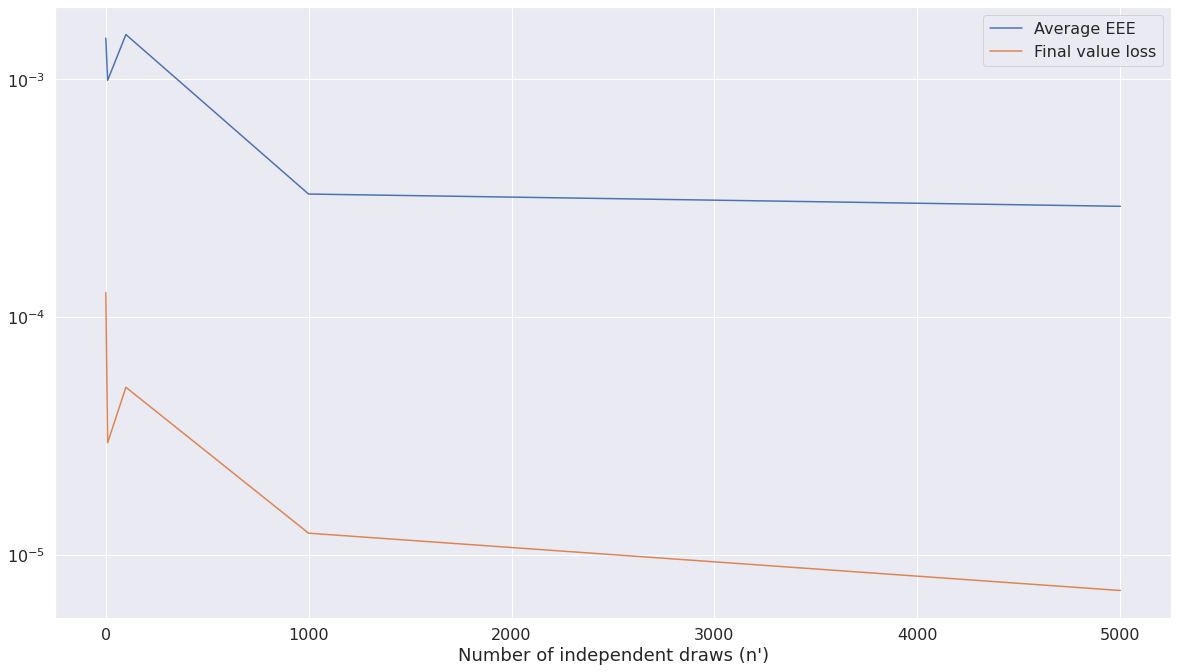

In [41]:
df_hyperparameters['abs_final_loss'] = np.abs(df_hyperparameters['final_loss'])
plt.plot(df_hyperparameters['T'],df_hyperparameters['mean_perc_abs_error'], label="Average EEE")
plt.plot(df_hyperparameters['T'],df_hyperparameters['abs_final_loss'], label="Final value loss")
plt.yscale("log")
plt.xlabel("Number of independent draws (n')")
plt.legend()

---

## References

* Beck, P., Garcia Sanchez, P., Moura, A., Pascal, J., & Pierrard, O. 204. *Deep Learning Solution of DSGE Models: A Technical Report*. BCL Working Paper n°184. url: https://www.bcl.lu/fr/Recherche/publications/cahiers_etudes/184/index.html